## 1. Motivation

For our first dataset, we chose London’s public bike-sharing data from Santander Cycles, which consists of the number of bicycle hires per day from 2010 to 2022. The second dataset we wanted to combine with the bike hiring one, is the weather in London dataset (2010-2020) with data about wind speed, visibility, air temperature, humidity, etc., and the third one is COVID-19 in London dataset (2019-2021), which includes COVID-19 cases, and age of infected people. For the bicycle movements we used movements of shared bikes (Santander Cycles) in London, consisting of the duration of the rent, bike id, and start and end stations ids and names. In order to add the longitude and latitude of the stations so we could visualize them, we decided to use the bike stations dataset, since it contains the necessary data. The last dataset we used is routing dataset to get length and duration of the trip.

Cities all over the world are embracing cycling as a rational, practical part of their transportation system. Bicycles improve health, ease congestion, save money, use less space, and provide efficient transportation with zero fuel consumption and zero carbon emissions. We wanted to analyze bike hiring behavior in London based on mentioned data over the years and make predictions. We chose London due to its vast public data availability.

Our goal was to analyze what affects bike rental numbers (bad weather, pandemic), and then predict what is to be expected in the future. Can London become a greener city? We also wanted to see which stations and routes are used the most to get some insight into people's interests.

## 2. Basic stats

For the bike hiring dataset, we divided the dataset into three new ones due to cleaning the one we used, and then we dropped all rows with NaN values. The weather dataset was messy and contained a lot of data we didn’t need for our analysis, so it needed a lot of cleaning. We removed the rows that contained zeros, columns that are not relevant as ids and method and manner of measurement, and at the end, we merged the dataset with the bike hiring one. For the COVID-19 dataset we removed columns "area_code" and "area_name" due to all cases being in London, we converted column "date" to dataframe, removed rows that contained NaN values, and merged the dataset with the bike rental dataset. We merged the bike movements and bike stations to have one dataset that has all relevant data for the analysis. As for the routing dataset, we extract the length and duration of trips from the "summary" column, add the "datetime" column with values from the "Start Date" column from the bike movements dataset, and converted the values to datetime. In the end, we merged the datasets.  

In [370]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from pathlib import Path
from datetime import datetime as dt
import seaborn as sns
# import datetime
# import shaply
from shapely.geometry import Point, Polygon
import fiona # fiona needs to be imported before geopandas (otherwise gdp does not work properly)
import geopandas as gpd
import json
from pyproj import CRS
import plotly.graph_objects as go
import folium
from folium import plugins


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Pre-Processing

In [398]:
# import data

# bike rentals (https://data.london.gov.uk/dataset/number-bicycle-hires)
# metadata = pd.read_excel(Path.cwd().parent/"files"/"tfl-daily-cycle-hires.xlsx")
bike_rentals = pd.read_excel(Path.cwd().parent/"files"/"Assignment3"/"bike_rentals_london.xlsx", sheet_name = 'Data')

# covid (https://data.london.gov.uk/dataset/coronavirus--covid-19--cases)
covid = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/"corona_london.csv")

# weather (https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202107/greater-london/00708_heathrow/qc-version-1)
# metadata od the weather data (https://artefacts.ceda.ac.uk/badc_datadocs/ukmo-midas/WH_Table.html)
li = []

for i in range(2010,2020,1):

    dummy = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/f"London_weather_{i}_heathrow.csv", header = 280)
    li.append(dummy)

weather = pd.concat(li, axis=0, ignore_index=True)

del li, dummy, i

In [399]:
# Preprocessing bike rental data

bike_rentals_month = bike_rentals[['Month', 'Number of Bicycle Hires.1', 'Average Hire Time (mins)']]
# drop NaN rows
bike_rentals_month = bike_rentals_month[bike_rentals_month['Number of Bicycle Hires.1'].notna()]

bike_rentals_year = bike_rentals[['Year', 'Number of Bicycle Hires.2']]
bike_rentals_year = bike_rentals_year.iloc[:bike_rentals_year.Year.isnull().values.argmax()]

bike_rentals = bike_rentals.drop(columns = ['Unnamed: 2', 'Unnamed: 5', 'Unnamed: 8', 'Month.1', 'Month', 'Number of Bicycle Hires.1', \
    'Average Hire Time (mins)', 'Year', 'Number of Bicycle Hires.2'])

print(bike_rentals.describe())
bike_rentals.head()

       Number of Bicycle Hires
count              4204.000000
mean              26320.135347
std                9693.146364
min                2764.000000
25%               19271.000000
50%               26145.500000
75%               33371.000000
max               73094.000000


Day  Number of Bicycle Hires
0 2010-07-30                     6897
1 2010-07-31                     5564
2 2010-08-01                     4303
3 2010-08-02                     6642
4 2010-08-03                     7966

<AxesSubplot:xlabel='Day', ylabel='Number of Bicycle Hires'>

<Figure size 3000x7500 with 0 Axes>

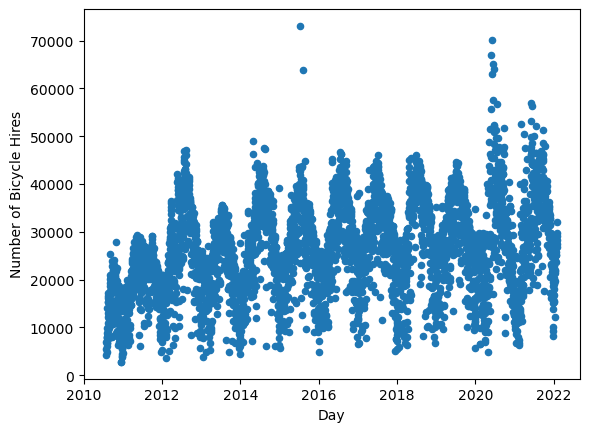

In [400]:
# a chronological scatter plot of the rental numbers
plt.figure(figsize=(30, 75))
bike_rentals.plot.scatter(x='Day', y='Number of Bicycle Hires')

In [401]:
# Preprocessing weather data

# drop columns with only NaNs
weather = weather.dropna(axis=1, how='all')
# drop rows with only NaNs
weather = weather.dropna(axis=0, how='all')
# drop columns version_num as all values = 1.0, id as all values = 3772, met_domain_name as all values = SYNOP,
# id_type = WMO , 'src_id' = 708
weather = weather.drop(columns = ['version_num', 'id', 'met_domain_name', 'id_type', 'src_id'])
# drop rows where ob_time == 'end data' as all other rows are NaN
weather = weather.drop(weather[weather.ob_time == 'end data'].index)
# drop column wind_speed_unit_id as all values = 4
weather = weather.drop(columns = ['wind_speed_unit_id'])
# drop columns as the method and manner of measurement are not relevant for this analysis
weather = weather.drop(columns = ['rec_st_ind', 'src_opr_type', 'air_temperature_q', 'dewpoint_q', 'wetb_temp_q', 'dewpoint_j', \
    'wetb_temp_j', 'rltv_hum_j', 'midas_stmp_etime', 'meto_stmp_time', 'prst_wx_id'])
# quality control out of the scope of the project -> drop all columns
weather = weather.drop(columns = ['wind_direction_q', 'wind_speed_q', 'prst_wx_id_q', 'cld_ttl_amt_id_q', 'cld_base_ht_q',\
    'visibility_q', 'msl_pressure_q', 'cld_amt_id_1_q', 'cld_base_ht_id_1_q', 'cld_amt_id_2_q', 'cld_base_ht_id_2_q', 'cld_amt_id_3_q',\
    'cld_base_ht_id_3_q', 'stn_pres_q', 'alt_pres_q', 'q10mnt_mxgst_spd_q', 'wmo_hr_sun_dur_q', 'snow_depth_q', 'drv_hr_sun_dur',\
    'drv_hr_sun_dur_q'])
# drop columns not necessary for analysis
weather = weather.drop(columns = ['alt_pres', 'cld_amt_id_1', 'cld_base_ht_id_1', 'cld_amt_id_2', 'cld_base_ht_id_2', 'cld_amt_id_3',\
    'cld_base_ht_id_3', 'q10mnt_mxgst_spd', 'snow_depth', 'cavok_flag'])

# drop rows where air_temperature or wind_speed = NaN
weather = weather[weather['air_temperature'].notna()]
weather = weather[weather['wind_speed'].notna()]
# converting date to datetime
weather['ob_time'] = pd.to_datetime(weather['ob_time'])
# group by day to be able to merge it with the bike rental data
weather = weather.groupby(weather['ob_time'].dt.date).mean().reset_index()
weather['ob_time'] = pd.to_datetime(weather['ob_time'])

## optional
# drop rows where cld_ttl_amt_id, cld_base_ht, visibility, wmo_hr_sun_dur depending on analysis
# weather = weather[weather['cld_ttl_amt_id'].notna()]
# weather = weather[weather['cld_base_ht'].notna()]
# weather = weather[weather['visibility'].notna()]
# weather = weather[weather['wmo_hr_sun_dur'].notna()]

## checks
# NaN check 
print(weather.isna().sum())

## Preprocessing combing bike rentals and weather data by joining on the datetime
# dropping ob_time as similar to Day

bike_rentals_weather = pd.merge(bike_rentals, weather, left_on='Day', right_on='ob_time')
bike_rentals_weather = bike_rentals_weather.drop(columns=['ob_time'])
print(bike_rentals_weather.describe().T)
bike_rentals_weather.head()

ob_time             0
wind_direction      0
wind_speed          0
cld_ttl_amt_id     43
cld_base_ht        43
visibility          2
msl_pressure        0
air_temperature     0
dewpoint            0
wetb_temp           0
rltv_hum            0
stn_pres            0
wmo_hr_sun_dur     10
dtype: int64
                          count          mean          std          min           25%           50%           75%           max
Number of Bicycle Hires  3430.0  25700.722157  9227.871616  2764.000000  19143.750000  25616.000000  32544.500000  73094.000000
wind_direction           3430.0    195.499024    72.062422    18.750000    148.854167    212.916667    247.916667    352.500000
wind_speed               3430.0      8.028507     3.329078     1.541667      5.541667      7.458333      9.875000     23.416667
cld_ttl_amt_id           3387.0      4.808249     2.331597     0.000000      3.083333      5.208333      6.833333      8.291667
cld_base_ht              3387.0    138.152566    62.576971   

Day  Number of Bicycle Hires  wind_direction  wind_speed  cld_ttl_amt_id  cld_base_ht   visibility  msl_pressure  air_temperature   dewpoint  wetb_temp   rltv_hum     stn_pres  wmo_hr_sun_dur
0 2010-07-30                     6897      267.500000    6.791667        5.500000   123.750000  1883.333333   1014.687500        17.558333  10.479167  13.741667  64.450000  1011.712500        0.130435
1 2010-07-31                     5564      240.000000    9.333333        5.291667   102.083333  2919.583333   1011.554167        19.858333  13.708333  16.358333  69.808333  1008.612500        0.204348
2 2010-08-01                     4303      261.250000    5.916667        7.208333   156.666667  2879.166667   1013.225000        18.795833  11.125000  14.591667  62.675000  1010.266667        0.017391
3 2010-08-02                     6642      247.083333    4.708333        6.500000   173.333333  2470.833333   1016.791667        18.837500  10.483333  14.304167  59.066667  1013.833333        0.091304
4 2010-08-03                     7966      256.666667    6.750000        4.666667   177.083333  1908.333333   1015.687500        17.870833  11.225000  14.225000  66.145833  1012.729167        0.169565

<AxesSubplot:xlabel='air_temperature', ylabel='Number of Bicycle Hires'>

<Figure size 3000x7500 with 0 Axes>

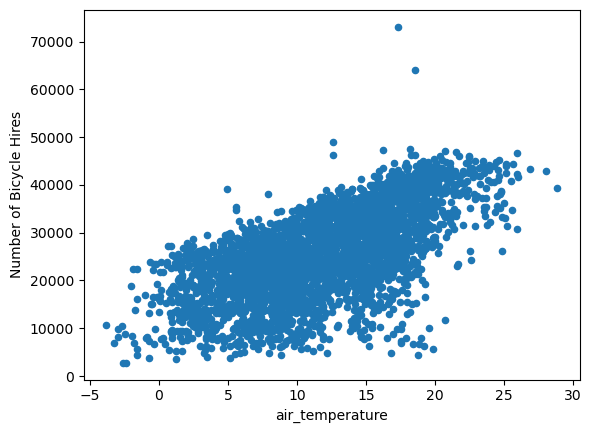

In [402]:
# creating a scatter plot of the rental numbers against the air temperature
plt.figure(figsize=(30, 75))
bike_rentals_weather.plot.scatter(x='air_temperature', y='Number of Bicycle Hires')

<AxesSubplot:xlabel='rltv_hum', ylabel='Number of Bicycle Hires'>

<Figure size 3000x7500 with 0 Axes>

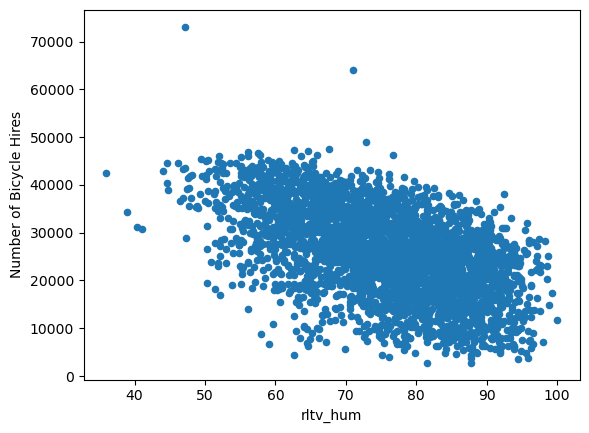

In [403]:
# creating a scatter plot of the rental numbers against the relative humidity
plt.figure(figsize=(30, 75))
bike_rentals_weather.plot.scatter(x='rltv_hum', y='Number of Bicycle Hires')

In [404]:
# Preprocessing covid data

# drop all dates without age information
covid = covid[covid.age_band != 'unassigned']
# drop columns area_name, area_code
covid = covid.drop(columns = ['area_name', 'area_code'])
# converting date to datetime
covid['date'] = pd.to_datetime(covid['date'])

## checks
# NaN check 
print(covid.isna().sum())

# Preprocessing combing bike rentals and covid data by joining on the datetime
# drop date as similar to Day

bike_rentals_covid = pd.merge(bike_rentals, covid, left_on='Day', right_on='date')
bike_rentals_covid = bike_rentals_covid.drop(columns=['date'])
print(bike_rentals_covid.describe().T)
bike_rentals_covid.head()

date            0
cases           0
rolling_sum     0
rolling_rate    0
age_band        0
age_lower       0
age_higher      0
population      0
dtype: int64
                           count           mean            std      min        25%       50%       75%       max
Number of Bicycle Hires  13851.0   29324.755830   11259.519725   4872.0   21173.00   29221.0   37527.0   70170.0
cases                    13851.0     173.198397     408.984842      0.0       6.00      32.0     165.0    6834.0
rolling_sum              13851.0    1196.396072    2734.724978      0.0      40.00     225.0    1160.0   37363.0
rolling_rate             13851.0     223.188434     423.082395      0.0      12.95      68.2     232.7    4930.1
age_lower                13851.0      45.000000      27.387117      0.0      20.00      45.0      70.0      90.0
age_higher               13851.0      48.789474      27.053711      4.0      24.00      49.0      74.0      90.0
population               13851.0  473815.157895  226

Day  Number of Bicycle Hires  cases  rolling_sum  rolling_rate       age_band  age_lower  age_higher  population
0 2020-02-03                    28267      0            0           0.0    0 - 4 years        0.0         4.0    595799.0
1 2020-02-03                    28267      0            0           0.0    5 - 9 years        5.0         9.0    606333.0
2 2020-02-03                    28267      0            0           0.0  10 - 14 years       10.0        14.0    550753.0
3 2020-02-03                    28267      0            0           0.0  15 - 19 years       15.0        19.0    474456.0
4 2020-02-03                    28267      1            0           0.0  20 - 24 years       20.0        24.0    556594.0

# Covid Analysis

In [405]:
# further preprocessing the covid data by adding age groups
bins= [0.0,15.0,30.0,60.0,91.0]
labels = ['Child','Young Adult','Middle-Age Adult','Senior-Citizen']
bike_rentals_covid['AgeGroup'] = pd.cut(bike_rentals_covid['age_lower'], bins=bins, labels=labels, right=False)
bike_rentals_covid = bike_rentals_covid.drop(["age_band"], axis=1)
bike_rentals_covid.head()

Day  Number of Bicycle Hires  cases  rolling_sum  rolling_rate  age_lower  age_higher  population     AgeGroup
0 2020-02-03                    28267      0            0           0.0        0.0         4.0    595799.0        Child
1 2020-02-03                    28267      0            0           0.0        5.0         9.0    606333.0        Child
2 2020-02-03                    28267      0            0           0.0       10.0        14.0    550753.0        Child
3 2020-02-03                    28267      0            0           0.0       15.0        19.0    474456.0  Young Adult
4 2020-02-03                    28267      1            0           0.0       20.0        24.0    556594.0  Young Adult

<AxesSubplot:title={'center':'cases'}, xlabel='AgeGroup'>

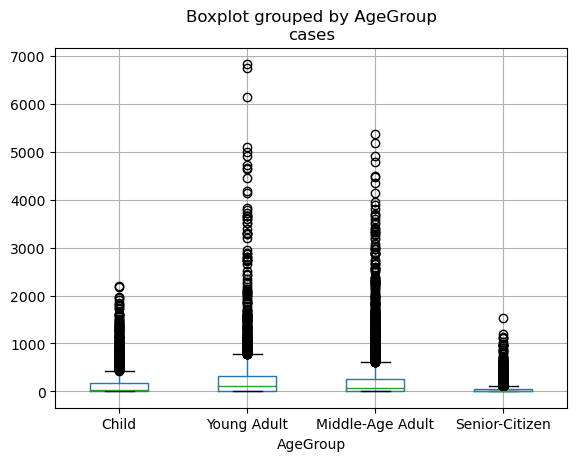

In [46]:
# using a boxplot to analyse the different age groups
bike_rentals_covid.boxplot('cases','AgeGroup')

In [407]:
# adding columns for the year, date, day, month, day of the week, weekend and season
bike_rentals_covid['year']=bike_rentals_covid.Day.dt.year
bike_rentals_covid['pickup_date']=bike_rentals_covid.Day.dt.date
bike_rentals_covid['pickup_day']=bike_rentals_covid.Day.dt.day
bike_rentals_covid['pickup_month']=bike_rentals_covid.Day.dt.month

# Extracting the day of the week (dow)
bike_rentals_covid['pickup_dow'] = pd.to_datetime(bike_rentals_covid['Day']).dt.dayofweek

# Type of day column
bike_rentals_covid['pickup_weekend'] = bike_rentals_covid.Day.dt.dayofweek.apply(lambda x: '0' if x <5 else '1')

# Adding the season
bike_rentals_covid['season']=bike_rentals_covid.Day.dt.month.apply(lambda x: 'Winter' if x <=2 else 'Spring' if x<=5 else 'Summer' 
                                             if x<=8 else 'Autumn' if x<=11 else 'Winter')

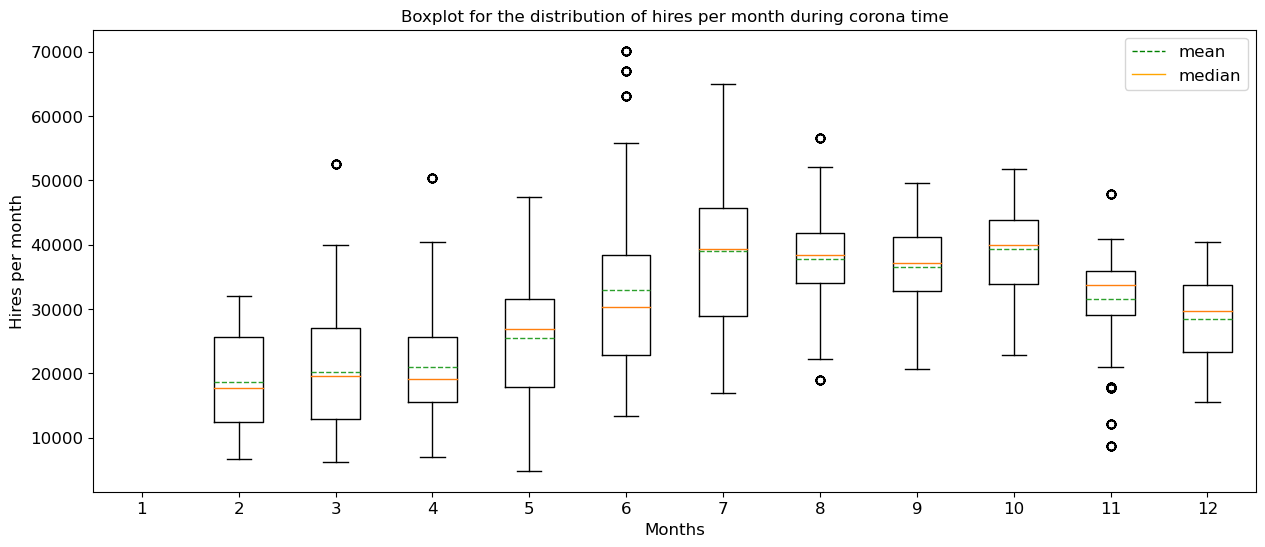

In [408]:
# creating a boxplot to analyse the different months
figure = plt.figure(figsize =(15, 6))
bikes_month=[]
for i in range(0,12):
    bikes_month.append(bike_rentals_covid[bike_rentals_covid['pickup_month']==i]['Number of Bicycle Hires'])
    #print(len(bikes[bikes['starttime_hour']==i]['pickups/hr'])) #363-365 because we remove >80 
    # Creating plot
plt.boxplot(bikes_month, showmeans=True, meanline= True)
plt.plot([], [], '--', linewidth=1, color='Green', label='mean')
plt.plot([], [], '-', linewidth=1, color='orange', label='median')
plt.xlabel("Months", fontsize=12)
plt.ylabel("Hires per month", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title("Boxplot for the distribution of hires per month during corona time")
plt.show()

In [409]:
# grouping the data by day of the week and season to analyse the number of hires
covid_hires_per_season=bike_rentals_covid.groupby(['pickup_dow','season']).mean()['Number of Bicycle Hires'].reset_index()
covid_hires_per_season.head()

pickup_dow  season  Number of Bicycle Hires
0           0  Autumn             30097.538462
1           0  Spring             24130.703704
2           0  Summer             33763.518519
3           0  Winter             17984.000000
4           1  Autumn             33323.846154

In [410]:
# grouping the data by day of the week and weekend to analyse the number of hires
covid_hires_per_dow=bike_rentals_covid.groupby(['pickup_dow','pickup_weekend']).mean()['Number of Bicycle Hires'].reset_index()
covid_hires_per_dow.head()

pickup_dow pickup_weekend  Number of Bicycle Hires
0           0              0             26621.714286
1           1              0             28847.163462
2           2              0             28816.971154
3           3              0             28499.365385
4           4              0             29066.423077

Text(0.5, 1.0, 'Hires per season')

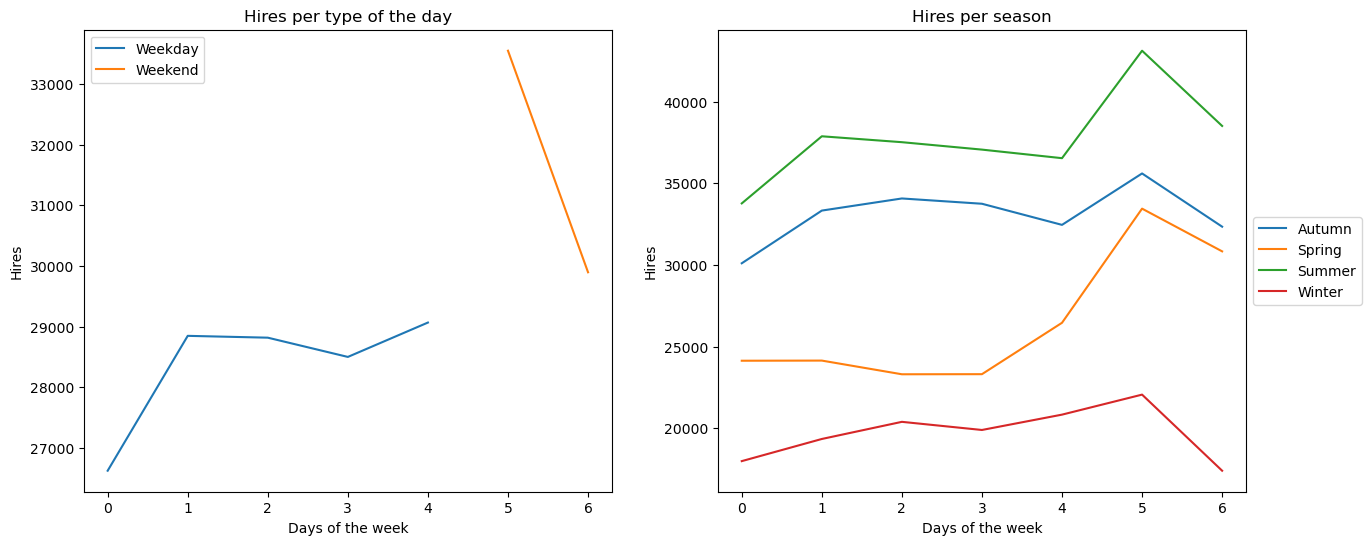

In [411]:
#Plotting pickups based on the type of the day and the season
 
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
#ax = plt.gca()
for weekday in covid_hires_per_dow['pickup_weekend'].unique():
    covid_hires_per_dow[covid_hires_per_dow.pickup_weekend==weekday].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[0],xlabel='Days of the week',ylabel='Hires')
axes[0].legend(['Weekday','Weekend'])
axes[0].set_title('Hires per type of the day')


for season in covid_hires_per_season['season'].unique():
    covid_hires_per_season[covid_hires_per_season.season==season].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[1],xlabel='Days of the week',ylabel='Hires')
axes[1].legend(covid_hires_per_season['season'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Hires per season')

In [413]:
# grouping data by day of the week and age group to analyse the covid cases
covid_cases_per_agegroup=bike_rentals_covid.groupby(['pickup_dow','AgeGroup']).mean()['cases'].reset_index()
covid_cases_per_agegroup.head()

pickup_dow          AgeGroup       cases
0           0             Child  195.355556
1           0       Young Adult  348.917460
2           0  Middle-Age Adult  300.622222
3           0    Senior-Citizen   51.619048
4           1             Child  177.163462

Text(0.5, 1.0, 'Covid-19 cases per day of the week per age group')

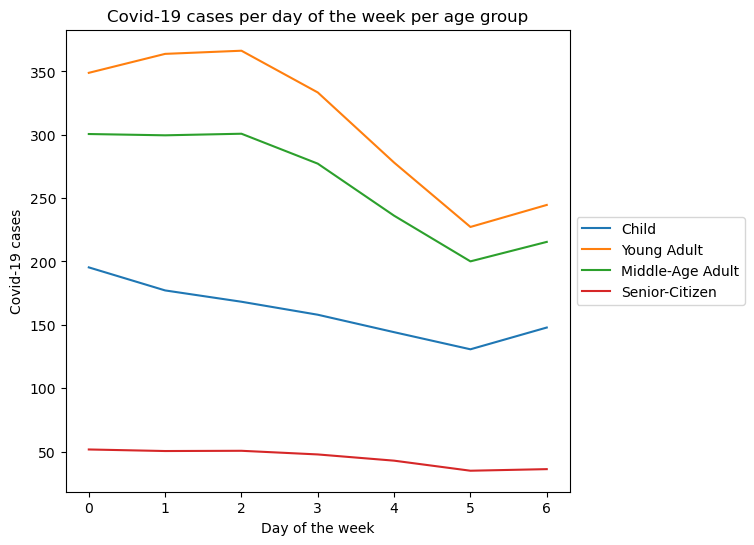

In [414]:

ax = plt.gca()
for agegroup in covid_cases_per_agegroup['AgeGroup'].unique():
    covid_cases_per_agegroup[covid_cases_per_agegroup.AgeGroup==agegroup].plot(kind='line',x='pickup_dow',y='cases',ax=ax,xlabel='Day of the week',ylabel='Covid-19 cases',figsize=(6.5,6))
plt.legend(covid_cases_per_agegroup['AgeGroup'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covid-19 cases per day of the week per age group')

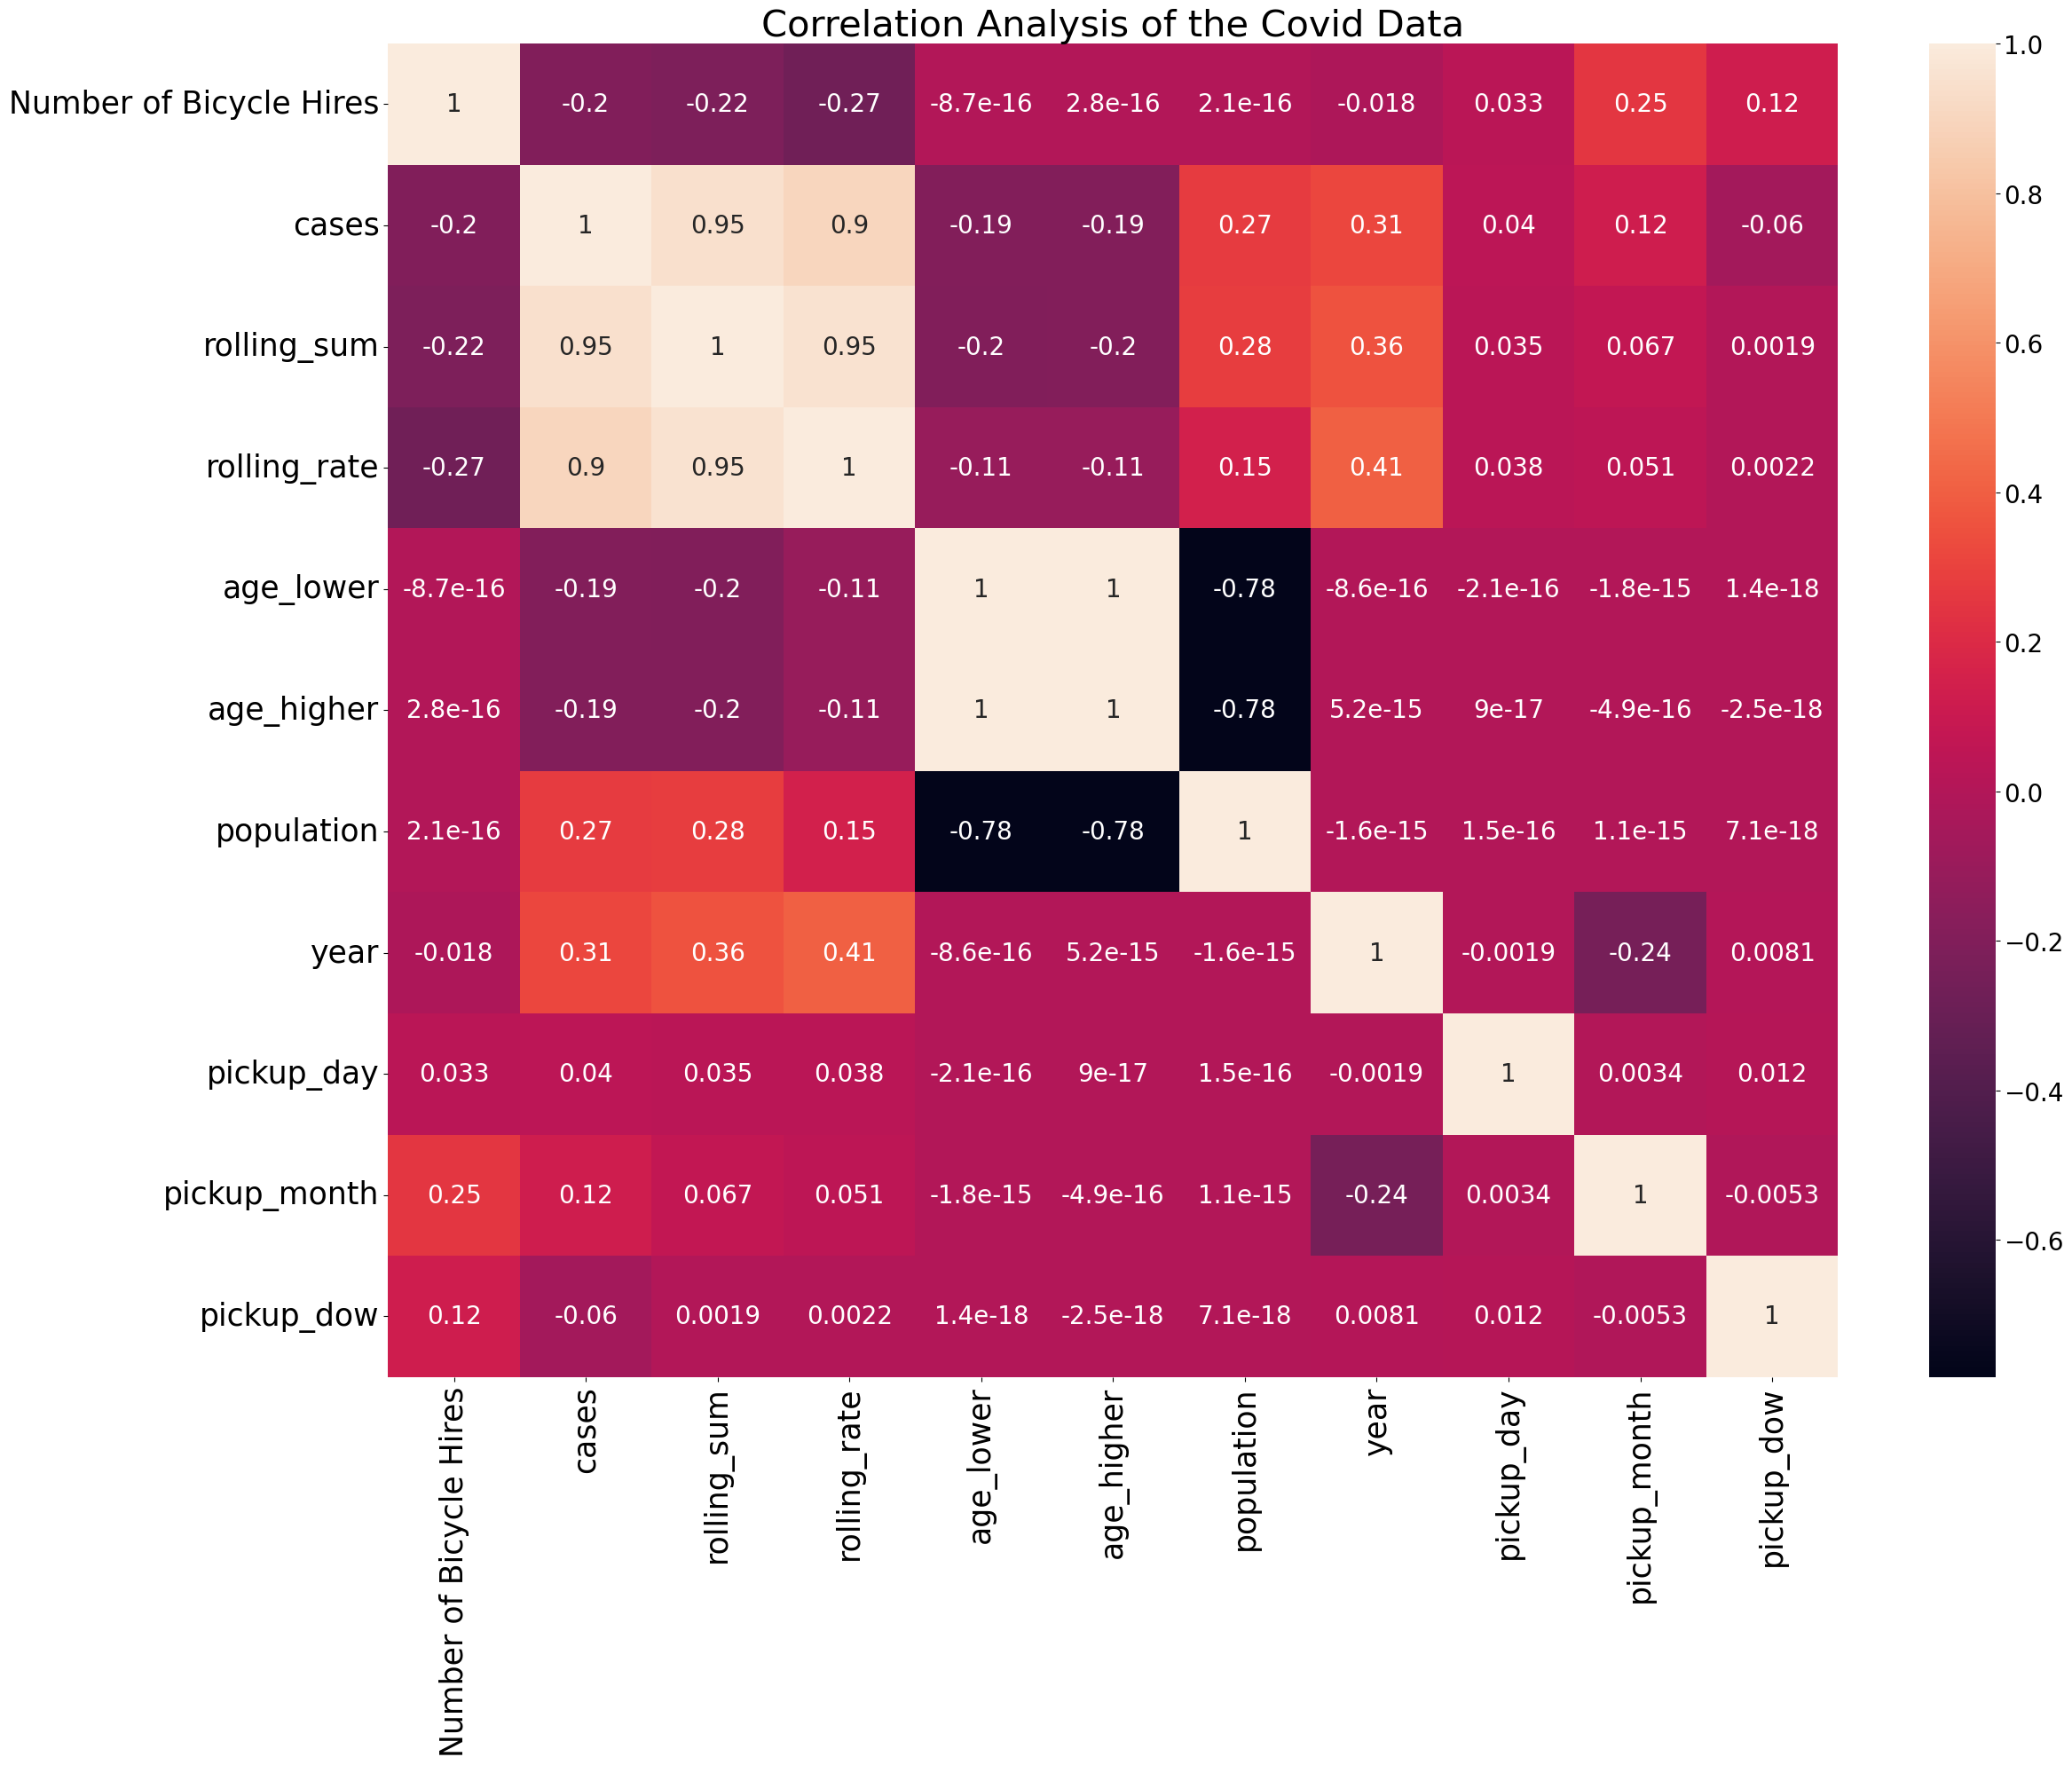

In [423]:
corrMatrix = bike_rentals_covid.corr()
plt.figure(figsize=(25, 20))
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title('Correlation Analysis of the Covid Data', fontsize = 30)
plt.xticks(fontsize=25, rotation = 90)
plt.yticks(fontsize=25, rotation = 0)
plt.tight_layout()
plt.show()

# Bicycle Movements

In [74]:
# importing movements of shared bikes (Santander Cycles) in London 
# source: https://cycling.data.tfl.gov.uk/ (tfl = Transport for London)
cycling_load = json.load(open(Path.cwd().parent/"files"/"Assignment3"/"cycling-load.json"))

dfs = []

# use for loop in comment below if you want all the data -> download roughly 30 min
# for counter, url in enumerate(cycling_load['entries']):

# the loop downloads the data from TFL via the urls provided in cycling_load

for i in range(1):

    bike_movements = pd.read_csv(cycling_load['entries'][i]['url'])
    dfs.append(bike_movements)

bike_movements = pd.concat(dfs)

bike_movements.head()

Rental Id  Duration  Bike Id          End Date  EndStation Id                      EndStation Name        Start Date  StartStation Id                 StartStation Name
0   50754225       240    11834  10/01/2016 00:04          383.0                   Frith Street, Soho  10/01/2016 00:00               18         Drury Lane, Covent Garden
1   50754226       300     9648  10/01/2016 00:05          719.0  Victoria Park Road, Hackney Central  10/01/2016 00:00              479        Pott Street, Bethnal Green
2   50754227      1200    10689  10/01/2016 00:20          272.0                Baylis Road, Waterloo  10/01/2016 00:00              425  Harrington Square 2, Camden Town
3   50754228       780     8593  10/01/2016 00:14          471.0             Hewison Street, Old Ford  10/01/2016 00:01              487             Canton Street, Poplar
4   50754229       600     8619  10/01/2016 00:11          399.0        Brick Lane Market, Shoreditch  10/01/2016 00:01              501      Cephas Street, Bethnal Green

In [75]:
# importing stations of shared bikes (Santander Cycles) in London 
# source: https://api-portal.tfl.gov.uk/api-details#api=BikePoint&operation=BikePoint_GetAll

bike_stations = json.load(open(Path.cwd().parent/"files"/"Assignment3"/"bikepoint.json"))

In [76]:
# preprocessing the bike_stations
bike_stations = pd.DataFrame(bike_stations)
bike_stations = bike_stations.drop(['$type', 'url', 'placeType', 'additionalProperties', 'children', 'childrenUrls'], axis='columns')
bike_stations.head()

id                            commonName        lat       lon
0  BikePoints_1            River Street , Clerkenwell  51.529163 -0.109970
1  BikePoints_2        Phillimore Gardens, Kensington  51.499606 -0.197574
2  BikePoints_3  Christopher Street, Liverpool Street  51.521283 -0.084605
3  BikePoints_4       St. Chad's Street, King's Cross  51.530059 -0.120973
4  BikePoints_5         Sedding Street, Sloane Square  51.493130 -0.156876

In [77]:
# chaning the id from string to int e.g. 'BikePoints_1' -> 1
list_id = list(range(1,len(bike_stations)+1))
bike_stations['id'] = list_id
bike_stations.head()

id                            commonName        lat       lon
0   1            River Street , Clerkenwell  51.529163 -0.109970
1   2        Phillimore Gardens, Kensington  51.499606 -0.197574
2   3  Christopher Street, Liverpool Street  51.521283 -0.084605
3   4       St. Chad's Street, King's Cross  51.530059 -0.120973
4   5         Sedding Street, Sloane Square  51.493130 -0.156876

In [78]:
# combining the bike movements with the bike stations

bike_movements = pd.merge(bike_movements, bike_stations, left_on="StartStation Id", right_on="id")
bike_movements = bike_movements.rename(columns={'id': 'id_start', 'lon' : 'lon_start', 'lat' : 'lat_start'})
bike_movements = pd.merge(bike_movements, bike_stations, left_on="EndStation Id", right_on="id")
bike_movements = bike_movements.rename(columns={'id': 'id_end', 'lon' : 'lon_end', 'lat' : 'lat_end'})
# bike_movements = bike_movements.dropna()
print(bike_movements.isnull().sum())

bike_movements.head()

Rental Id  Duration  Bike Id          End Date  EndStation Id     EndStation Name        Start Date  StartStation Id          StartStation Name  id_start                         commonName_x  lat_start  lon_start  id_end          commonName_y    lat_end   lon_end
0   50754225       240    11834  10/01/2016 00:04          383.0  Frith Street, Soho  10/01/2016 00:00               18  Drury Lane, Covent Garden        18            Drury Lane, Covent Garden  51.514770  -0.122219     383  Merchant Street, Bow  51.526578 -0.027581
1   50762493      1920     5987  10/01/2016 15:05          383.0  Frith Street, Soho  10/01/2016 14:33              717  Dunston Road , Haggerston       717            Irene Road, Parsons Green  51.473763  -0.197010     383  Merchant Street, Bow  51.526578 -0.027581
2   50858478      2460    11290  14/01/2016 18:42          383.0  Frith Street, Soho  14/01/2016 18:01              717  Dunston Road , Haggerston       717            Irene Road, Parsons Green  51.473763  -0.197010     383  Merchant Street, Bow  51.526578 -0.027581
3   50984312       720     9528  20/01/2016 18:04          383.0  Frith Street, Soho  20/01/2016 17:52              264  Tysoe Street, Clerkenwell       264  Finsbury Leisure Centre, St. Luke's  51.526008  -0.096317     383  Merchant Street, Bow  51.526578 -0.027581
4   51033373      1440    10824  22/01/2016 20:54          383.0  Frith Street, Soho  22/01/2016 20:30              264  Tysoe Street, Clerkenwell       264  Finsbury Leisure Centre, St. Luke's  51.526008  -0.096317     383  Merchant Street, Bow  51.526578 -0.027581

In [31]:
# remove?

# Import street map (source: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)
london_wards = gpd.read_file(Path.cwd().parent/"files"/"Assignment3"/"London-wards-2014_ESRI"/'London_Ward_CityMerged.shp')
london_wards = london_wards.to_crs('EPSG:4326')

# Creating new dataframe for storing relevant data for geo-visualization
# data_location=pd.DataFrame()

In [79]:
# creating a location column which contains latitude and longitude
bike_movements["location_rental_start"]=list(zip(bike_movements["lon_start"], bike_movements["lat_start"]))
bike_movements["location_rental_end"]=list(zip(bike_movements["lon_end"], bike_movements["lat_end"]))

######
## drop? commented part
# data_location["location_rental_start"]=bike_movements["location_rental_start"]
# data_location["location_rental_end"]=bike_movements["location_rental_end"]

# # Storing only unique locations
# data_location=data_location.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
# data_location=data_location.dropna()
######

# Caluclating how much each location is "visited" to get consumption
rental_starts = bike_movements.groupby(by=['location_rental_start']).agg({'location_rental_start':'count'}).\
    rename(columns={'location_rental_start':'count'}).reset_index()
rental_starts = gpd.GeoDataFrame(rental_starts, crs = "epsg:4326", geometry = rental_starts.location_rental_start.apply(Point))

rental_ends = bike_movements.groupby(by=['location_rental_end']).agg({'location_rental_end':'count'}).\
    rename(columns={'location_rental_end':'count'}).reset_index()
rental_ends = gpd.GeoDataFrame(rental_ends, crs = "epsg:4326", geometry = rental_ends.location_rental_end.apply(Point))



In [92]:
# requesting here routing api to get bicycle routes between start and end stations
# start and end stations in epsg:4326 are send to the api to get the routes

import os

from here_location_services import LS
from here_location_services.config.routing_config import ROUTING_RETURN
from here_map_widget import Map, Marker, GeoJSON

# here api bicycle routing still in beta -> Bicycle routing uses the pedestrian road network, where roads are considered to be open 
# for cycling.

# ls = LS(api_key="") # removed personal api key due to privacy reasons

# gdfs = []

# for i in range(800):
#     result = ls.bicycle_route(
#         origin=[float(bike_movements['lat_start'].values[i]), float(bike_movements['lon_start'].values[i])],
#         destination=[float(bike_movements['lat_end'].values[i]), float(bike_movements['lon_end'].values[i])],
#         return_results=[
#             ROUTING_RETURN.polyline,
#             ROUTING_RETURN.elevation,
#             ROUTING_RETURN.summary,
#             ROUTING_RETURN.travelSummary,
#         ],
#     )

#     result = result.to_geojson()
#     result = gpd.GeoDataFrame.from_features(result['features'])
#     result['import_iteration'] = i
#     gdfs.append(result)

# routing_gdf = pd.concat(gdfs)
# routing_gdf = routing_gdf.reset_index()
# routing_gdf = routing_gdf.drop(columns=['index'], axis =1)
# routing_gdf = routing_gdf.set_crs('epsg:4326')

# storing geodataframe as api requests are limited
# routing_gdf.to_pickle(Path.cwd().parent/"files"/"Assignment3"/'routing_gdf')

# restoring geodataframe
routing_gdf = pd.read_pickle(Path.cwd().parent/"files"/"Assignment3"/'routing_gdf')
routing_gdf.head()


geometry                                    id        type                                          departure                                            arrival                                            summary                                      travelSummary                                           polyline               transport  import_iteration notices
0  LINESTRING Z (-0.12228 51.51474 72.00000, -0.1...  8d841f98-88f2-4211-8f65-40bbe555bb90  pedestrian  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'duration': 53, 'length': 24, 'baseDuration':...  {'duration': 53, 'length': 24, 'baseDuration':...                              B2Fm3moiDn6uHgtB9JkOA  {'mode': 'pedestrian'}                 0     NaN
1  LINESTRING Z (-0.12205 51.51458 72.00000, -0.1...  7455c8a2-b04d-4d1e-91c7-4616ef2c9bd6     vehicle  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'time': '2022-05-07T17:15:15+01:00', 'place':...  {'duration': 1820, 'length': 7369, 'baseDurati...  {'duration': 1820, 'length': 7369, 'baseDurati...  B2FotmoiDjsuHgtBzFjIA3S3cAzKnQAjI_JA3DjIAvCkIT...     {'mode': 'bicycle'}                 0     NaN
2  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  29d35029-0f4a-40db-aa78-dcbf637c3ebf     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 1     NaN
3  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  e8b6ec13-37bb-4663-851b-c42d621a1930     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 2     NaN
4  LINESTRING Z (-0.09642 51.52597 67.00000, -0.0...  5556e3d7-793a-451a-a12f-80fa43e0e41e     vehicle  {'time': '2022-05-07T16:44:03+01:00', 'place':...  {'time': '2022-05-07T17:08:13+01:00', 'place':...  {'duration': 1450, 'length': 5694, 'baseDurati...  {'duration': 1450, 'length': 5694, 'baseDurati...  B2Fk18oiDnq8F8pBjS0FA_EoBA7GoBAjNkDAvCoBA3NoGU...     {'mode': 'bicycle'}                 3     NaN

In [93]:
# analysing distances and durations of cycling trips + creating a datetime column

# extracting length and duration of summary
routing_gdf['length'] = [d.get('length') for d in routing_gdf.summary]
routing_gdf['duration'] = [d.get('duration') for d in routing_gdf.summary]
routing_gdf = pd.merge(routing_gdf, bike_movements[['Start Date']], left_on='import_iteration', right_index=True)
routing_gdf = routing_gdf.rename(columns={'Start Date': 'datetime'})
routing_gdf['datetime'] = pd.to_datetime(routing_gdf['datetime'], format="%d/%m/%Y %H:%M")
routing_gdf.head()

geometry                                    id        type                                          departure                                            arrival                                            summary                                      travelSummary                                           polyline               transport  import_iteration notices  length  duration            datetime
0  LINESTRING Z (-0.12228 51.51474 72.00000, -0.1...  8d841f98-88f2-4211-8f65-40bbe555bb90  pedestrian  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'duration': 53, 'length': 24, 'baseDuration':...  {'duration': 53, 'length': 24, 'baseDuration':...                              B2Fm3moiDn6uHgtB9JkOA  {'mode': 'pedestrian'}                 0     NaN      24        53 2016-01-10 00:00:00
1  LINESTRING Z (-0.12205 51.51458 72.00000, -0.1...  7455c8a2-b04d-4d1e-91c7-4616ef2c9bd6     vehicle  {'time': '2022-05-07T16:44:55+01:00', 'place':...  {'time': '2022-05-07T17:15:15+01:00', 'place':...  {'duration': 1820, 'length': 7369, 'baseDurati...  {'duration': 1820, 'length': 7369, 'baseDurati...  B2FotmoiDjsuHgtBzFjIA3S3cAzKnQAjI_JA3DjIAvCkIT...     {'mode': 'bicycle'}                 0     NaN    7369      1820 2016-01-10 00:00:00
2  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  29d35029-0f4a-40db-aa78-dcbf637c3ebf     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 1     NaN   14138      3489 2016-01-10 14:33:00
3  LINESTRING Z (-0.19689 51.47368 52.00000, -0.1...  e8b6ec13-37bb-4663-851b-c42d621a1930     vehicle  {'time': '2022-05-07T16:44:02+01:00', 'place':...  {'time': '2022-05-07T17:42:11+01:00', 'place':...  {'duration': 3489, 'length': 14138, 'baseDurat...  {'duration': 3489, 'length': 14138, 'baseDurat...  B2Fgx2liDzxgMwgBgKsTAoG8LAsO8aTwRkhBA0FgKA0FkI...     {'mode': 'bicycle'}                 2     NaN   14138      3489 2016-01-14 18:01:00
4  LINESTRING Z (-0.09642 51.52597 67.00000, -0.0...  5556e3d7-793a-451a-a12f-80fa43e0e41e     vehicle  {'time': '2022-05-07T16:44:03+01:00', 'place':...  {'time': '2022-05-07T17:08:13+01:00', 'place':...  {'duration': 1450, 'length': 5694, 'baseDurati...  {'duration': 1450, 'length': 5694, 'baseDurati...  B2Fk18oiDnq8F8pBjS0FA_EoBA7GoBAjNkDAvCoBA3NoGU...     {'mode': 'bicycle'}                 3     NaN    5694      1450 2016-01-20 17:52:00

In [94]:
# Summation of the lengths and durations of the split trips
# (the here routing api returns some returns trips in multiple sections)

routing_distances_durations = routing_gdf.groupby(by=['import_iteration']).agg({'length':'sum', 'duration':'sum'}).reset_index()

# adding datetime, start and end locations to dataframe
routing_distances_durations = pd.merge(routing_distances_durations, \
    bike_movements[['Start Date', 'location_rental_start', 'location_rental_end']], left_index=True, right_index=True)
routing_distances_durations = routing_distances_durations.rename(columns={'Start Date': 'datetime', 'length':'length [m]',\
    'duration': 'duration [min]'})
routing_distances_durations = routing_distances_durations[['datetime', 'location_rental_start', 'location_rental_end', 'length [m]',\
    'duration [min]', 'import_iteration']]
routing_distances_durations.head()

datetime   location_rental_start     location_rental_end  length [m]  duration [min]  import_iteration
0  10/01/2016 00:00   (-0.122219, 51.51477)  (-0.027581, 51.526578)        7393            1873                 0
1  10/01/2016 14:33   (-0.19701, 51.473763)  (-0.027581, 51.526578)       14138            3489                 1
2  14/01/2016 18:01   (-0.19701, 51.473763)  (-0.027581, 51.526578)       14138            3489                 2
3  20/01/2016 17:52  (-0.096317, 51.526008)  (-0.027581, 51.526578)        5694            1450                 3
4  22/01/2016 20:30  (-0.096317, 51.526008)  (-0.027581, 51.526578)        5694            1450                 4

In [118]:
# remove?

# import osm data for mapping
# source: https://download.geofabrik.de/europe/great-britain/england/greater-london.html
water_london = gpd.read_file(Path.cwd().parent/"files"/"Assignment3"/"gis_osm_water_a_free_1.shp")
buildings_london = gpd.read_file(Path.cwd().parent/"files"/"Assignment3"/"gis_osm_buildings_a_free_1.shp")
landuse_london = gpd.read_file(Path.cwd().parent/"files"/"Assignment3"/"gis_osm_landuse_a_free_1.shp")
roads_london = gpd.read_file(Path.cwd().parent/"files"/"Assignment3"/"gis_osm_roads_free_1.shp")

In [ ]:
# remove?  

# preprocessing osm data
landuse_london = landuse_london[~landuse_london['fclass'].isin(['commercial', 'industrial', 'military', 'quarry',  'residential', 'retail'])]


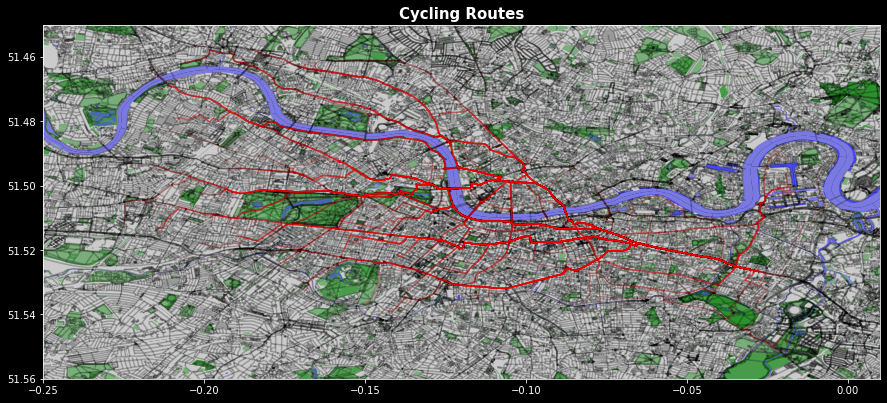

In [262]:
# remove? 

# Create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# Add .shp mapfile to axes
london_wards.plot(ax=ax, alpha=0.8, color = 'white')
landuse_london.plot(ax=ax, color = 'green',alpha=0.4)
water_london.plot(ax=ax, color = 'blue',alpha=0.4)
roads_london.plot(ax=ax, color = 'black',alpha=0.25)
# buildings_london.plot(ax=ax, color = 'orange',alpha=0.65)
# Add geodataframe to axes
# rental_starts.plot(column='count',ax=ax,alpha=0.8, legend=True,markersize=10, color = 'purple')
# rental_ends.plot(column='count',ax=ax,alpha=0.8, legend=True,markersize=10, color = 'red')
for i in range(routing_gdf.shape[0]):
    routing_gdf.loc[[i]].plot(ax=ax, alpha=0.05, color = 'red')

plt.title("Cycling Routes", fontsize=15,fontweight='bold')
# Set latitiude and longitude boundaries for map display
plt.xlim(-0.25,0.01)
plt.ylim(51.56,51.45)
plt.show()

In [95]:
# preprocessing data to plot routes on a folium map
# a datetime is added to plot them chronologically 

# special preprocessing is needed as we want to use the Folium plugin TimestampedGeoJson

routing_json = routing_gdf.copy()
routing_json['datetime'] = routing_json['datetime'].astype(str)
routing_json = routing_json.to_json()
routing_json = json.loads(routing_json)

lines = []

for i in range(routing_gdf.shape[0]):

    dct = {
        "coordinates": routing_json['features'][i]['geometry']['coordinates'],
        "dates": [routing_json['features'][i]['properties']['datetime']]*len(routing_json['features'][i]['geometry']['coordinates']),
        "color": "blue",
    }

    lines.append(dct)

lines = json.dumps(lines)
lines = json.loads(lines)

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": line["coordinates"],
        },
        "properties": {
            "times": line["dates"],
            "style": {
                "color": line["color"],
                "weight": line["weight"] if "weight" in line else 5,
                "opacity": 0.05,
            },
        },
    }
    for line in lines
]

In [ ]:
# Analysing the most used routes 

lat_London = 51.509865
lon_London = -0.118092

bike_routes_map = folium.Map(location=[lat_London, lon_London],tiles = 'CartoDB Positron',zoom_start=12,width=800,height=400,\
    control_scale=True, titles=None)

plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="P1D",
    add_last_point=False,
).add_to(bike_routes_map)

bike_routes_map.save("bike_routes_map.html")

bike_routes_map

In [ ]:
# remove? as old version

# # Start and End Stations of Bike Rentals in London

# lat_London = 51.509865
# lon_London = -0.118092

# bike_trips_map = folium.Map(location=[lat_London, lon_London],tiles = 'CartoDB Positron',zoom_start=12,width=800,height=800,\
#     control_scale=True, titles=None)

# for i in range(routing_gdf.shape[0]): 
#     folium.Choropleth(
#         routing_gdf.loc[[i]].geometry,
#         line_weight=3,
#         line_color='blue',
#         line_opacity=0.05
#     ).add_to(bike_trips_map)

# bike_trips_map.save("bike_trips_map.html")

# bike_trips_map

In [ ]:
# Start and End Stations of Bike Rentals in London
lat_London = 51.509865
lon_London = -0.118092

bike_rental_map = folium.Map(location=[lat_London, lon_London],tiles = 'CartoDB Positron',zoom_start=12,width=800,height=300,\
    control_scale=True, titles=None)

bike_rental_map.add_child(folium.plugins.FastMarkerCluster(bike_movements[["lat_start", "lon_start"]].values.tolist(), name = 'Starts'))
bike_rental_map.add_child(folium.plugins.FastMarkerCluster(bike_movements[["lat_end", "lon_end"]].values.tolist(), name = 'Ends'))

bike_rental_map.add_child(folium.LayerControl())

bike_rental_map.save("bike_rental_map.html")


bike_rental_map

In [47]:
# remove?

geo_json = result.to_geojson()
data = geo_json
geo_layer = GeoJSON(data=data, style={"lineWidth": 5})

m = Map(api_key='-0GaCuP83Kmdtm-YXTDGFg3QvXPUIBORvfCksk5RQLA', center=[float(bike_movements['lat_end'].values[0]), float(bike_movements['lon_end'].values[0])], zoom=14)
origin_marker = Marker(lat = float(bike_movements['lat_start'].values[0]), lng = float(bike_movements['lon_start'].values[0]))
dest_marker = Marker(lat = float(bike_movements['lat_end'].values[0]), lng = float(bike_movements['lon_end'].values[0]))
m.add_layer(geo_layer)
m.add_object(origin_marker)
m.add_object(dest_marker)
m

Map(api_key='-0GaCuP83Kmdtm-YXTDGFg3QvXPUIBORvfCksk5RQLA', center=[51.526578, -0.027581], controls=(ZoomContro…

# Weather analysis

In [ ]:
# we have data: cycling_load (bunch of stuff), weather, bike_rentals

plan: 
- check weather metadata (done)
- prune the bike rental data to exclude covid, (to match weather data time wise). (done)
- see what patterns can be seen if weather data is plotted against bike rentals.
    - plot things individually (done)
    - try to find correlation (the heatmap style) (done)
    - bin for each variable
- check classes for other tools / plots to make
- go through the cycling_load, what data it has, and what can i show with it.

In [103]:
#match times of the weather and bike rental data: bike rental starts from 2010 07 30 and finishes at 2022 01 31.
#while the weather data starts at: 2010 01 01 and finishes at 2019 12 31
#so we start with cutting the first half year of the weather data.
weatherCut = weather.loc[weather['ob_time'] >= dt.strptime("2010 7 30", "%Y %m %d" )]
weatherCut = weatherCut.reset_index()
bike_rentalsCut = bike_rentals.loc[bike_rentals['Day'] < dt.strptime("2020 1 1", "%Y %m %d" )]
#it appears to be that there is more bike rental data than weather by 12.
print(len(weatherCut))
type(bike_rentalsCut)

3430


pandas.core.frame.DataFrame

In [104]:
#we find any piece of data that does not exist in the other dataframe. 
#we find missing data in weather data but not the other way around
missingTimes = []
for time in bike_rentalsCut['Day']:
    listLikeObject = []
    listLikeObject.append(time)
    if not(weatherCut['ob_time'].isin(listLikeObject).any().any()):
        print('value does not exist in weatherCut', time)
        missingTimes.append(time)
        
for time in weatherCut['ob_time']:
    listLikeObject = []
    listLikeObject.append(time)
    if not(bike_rentalsCut['Day'].isin(listLikeObject).any().any()):
        print('value does not exist in bike_rentalsCut', time)

value does not exist in weatherCut 2013-05-08 00:00:00
value does not exist in weatherCut 2013-05-10 00:00:00
value does not exist in weatherCut 2013-05-11 00:00:00
value does not exist in weatherCut 2013-05-12 00:00:00
value does not exist in weatherCut 2013-05-13 00:00:00
value does not exist in weatherCut 2014-06-10 00:00:00
value does not exist in weatherCut 2014-06-11 00:00:00
value does not exist in weatherCut 2014-06-12 00:00:00
value does not exist in weatherCut 2014-06-13 00:00:00
value does not exist in weatherCut 2014-06-14 00:00:00
value does not exist in weatherCut 2014-06-15 00:00:00
value does not exist in weatherCut 2019-05-21 00:00:00


In [105]:
#then we remove the missing days from the bike rental data
dropindices = []
for missingTime in missingTimes:
    dropindices.append(bike_rentalsCut[bike_rentalsCut['Day'] == missingTime].index[0])

bike_rentalsCut = bike_rentalsCut.drop(index = dropindices)
weatherCut = weatherCut.reset_index()
bike_rentalsCut = bike_rentalsCut.reset_index()
#now we see that the dates are synced up. 
print(len(weatherCut))
print(len(bike_rentalsCut))

3430
3430


In [106]:
#rename columns to have the same name
weatherCut.rename(columns = {'ob_time':'Day'}, inplace = True)

#merge the dataframes
weatherJoined = pd.merge(weatherCut, bike_rentalsCut, on = "Day", how = "inner")

#drop not needed columns
weatherJoined.drop('index_x',axis=1, inplace = True)
weatherJoined.drop('level_0',axis=1, inplace = True)
weatherJoined.drop('index_y',axis=1, inplace = True)

#drop NAN values
weatherJoined.dropna(inplace=True)

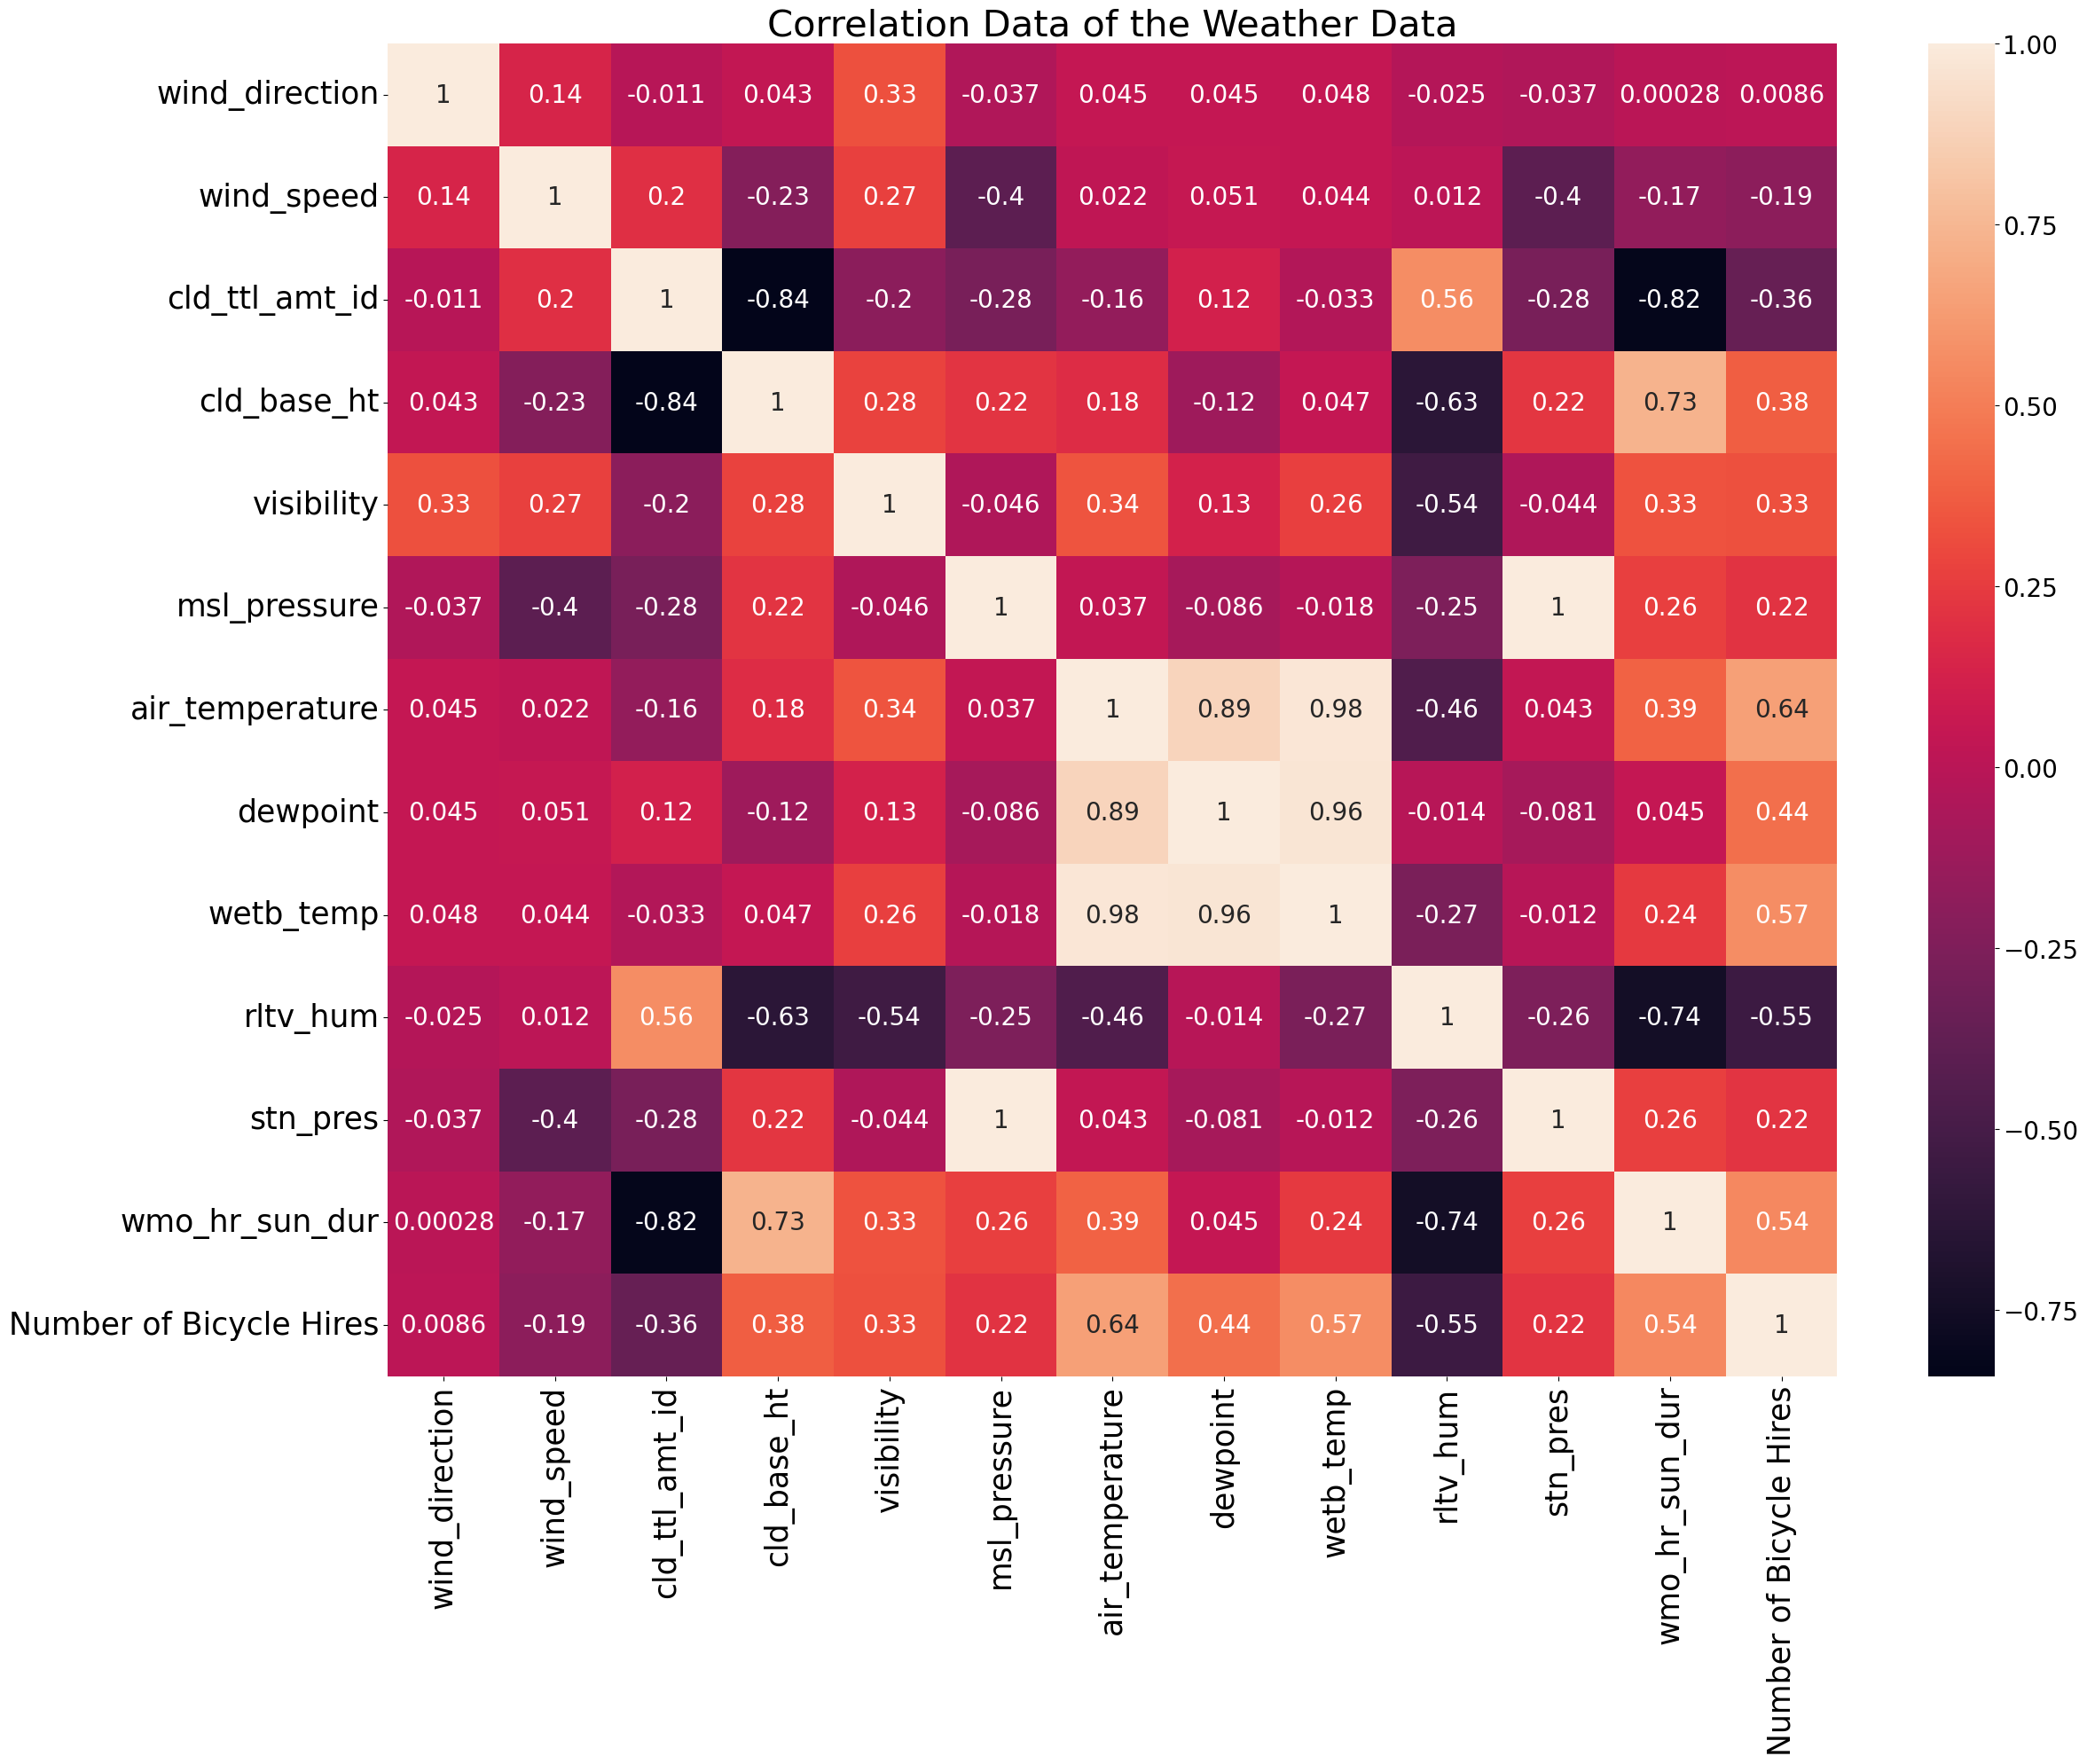

In [107]:
corrMatrix = weatherJoined.corr()
plt.figure(figsize=(25, 20))
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 20})
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.title('Correlation Data of the Weather Data', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

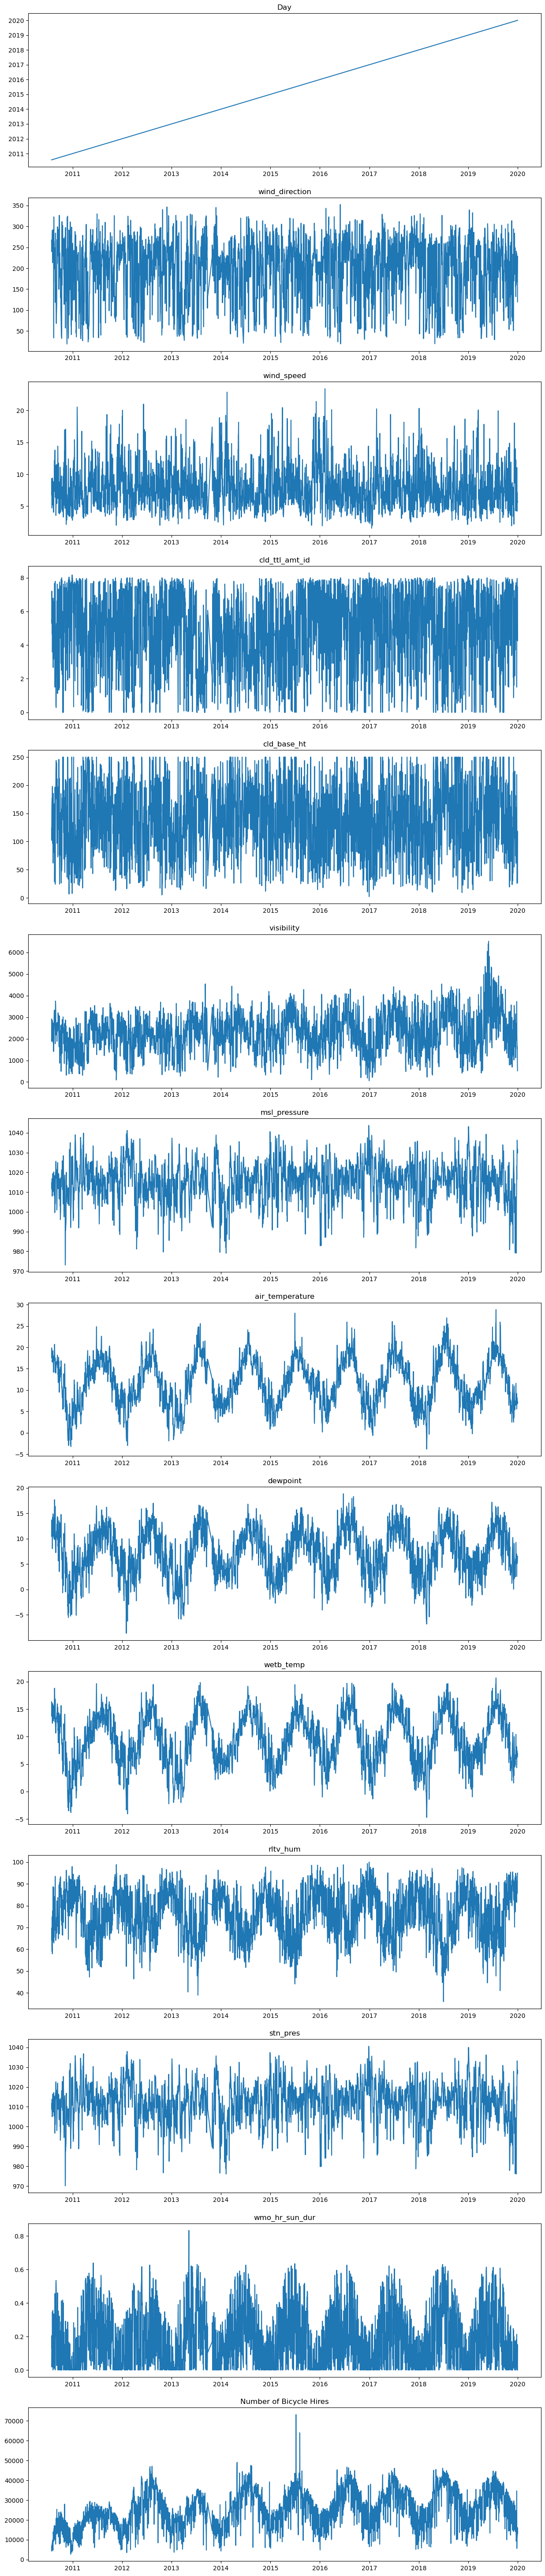

In [108]:
#plot everything compared to day, to get a feel how the variables change over time. 
plt.figure(figsize=(15, 75))
counter = 1
for col in weatherJoined.columns:
    ax = plt.subplot(len(weatherJoined.columns), 1, counter)
    ax.set_title(col)
    plt.plot(weatherJoined['Day'], weatherJoined[col])
    counter = counter + 1

In [109]:
# now we will try to bin for each variable, then make boxplots to see how it affects the rental numbers.
counter = 1

weatherBinned = pd.DataFrame(weatherJoined['Number of Bicycle Hires'])
for col in weatherJoined.columns:
    binColTitle = col + ' binned'
    bins = [weatherJoined[col].min(),
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.2,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.4,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.6,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.8, 
            weatherJoined[col].max()]
    labels = ['Lowest', 'Low', 'Medium', 'High', 'Highest']
    weatherBinned[binColTitle] = pd.cut(weatherJoined[col], bins, include_lowest = True, labels = labels)
    counter = counter + 1

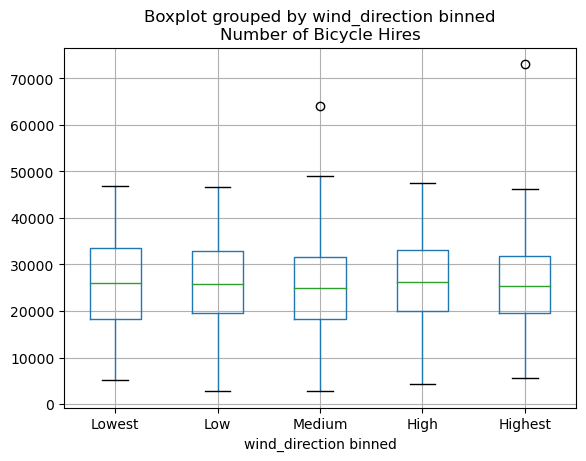

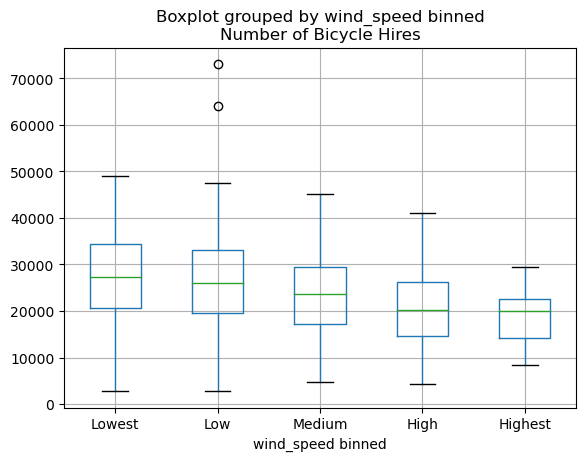

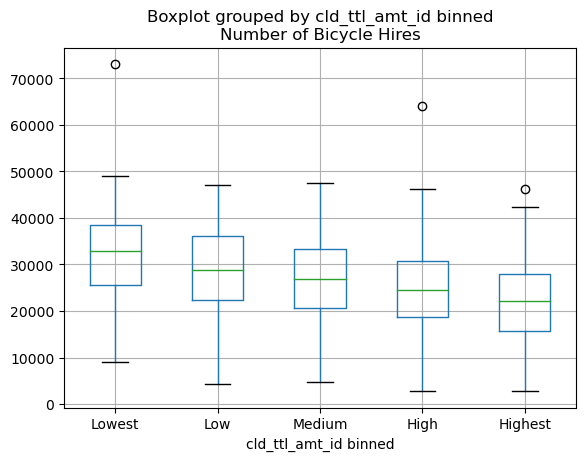

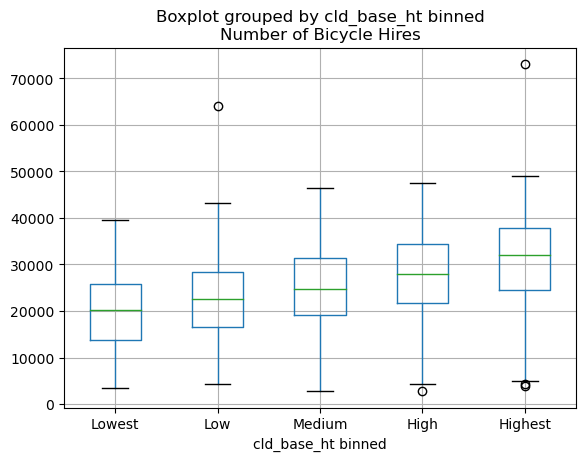

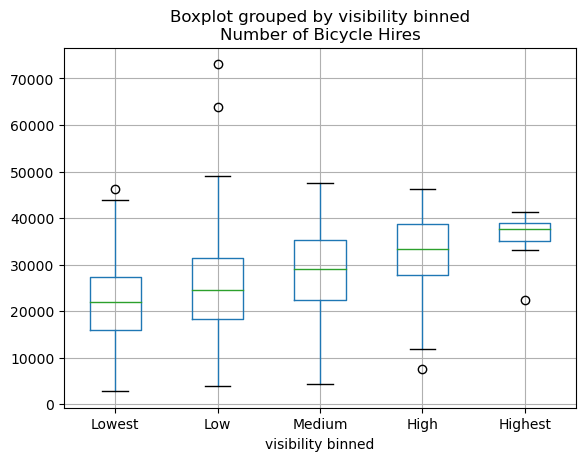

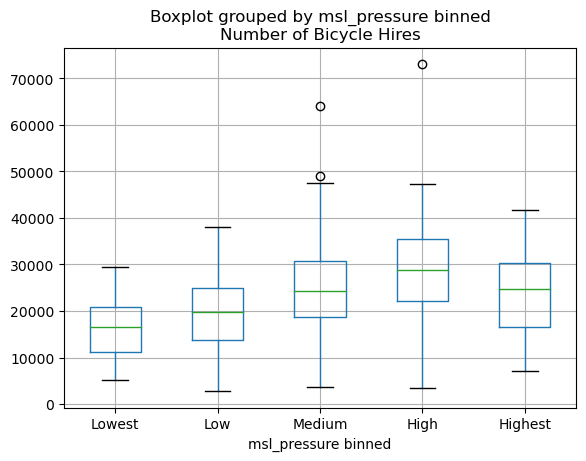

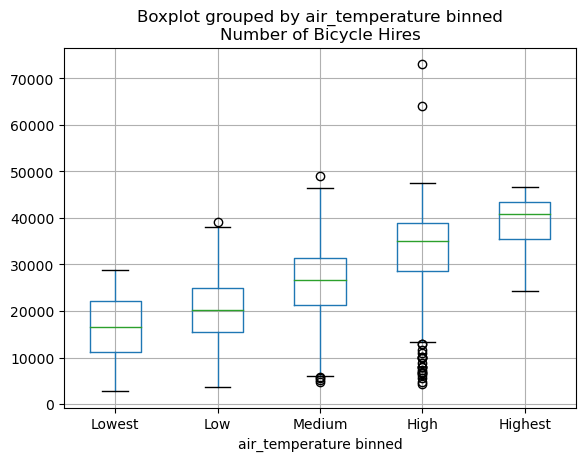

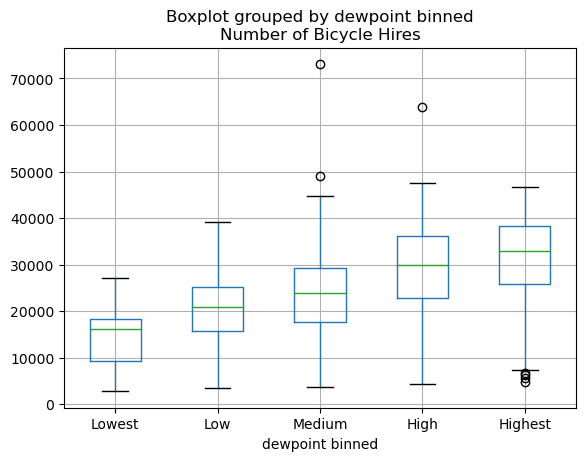

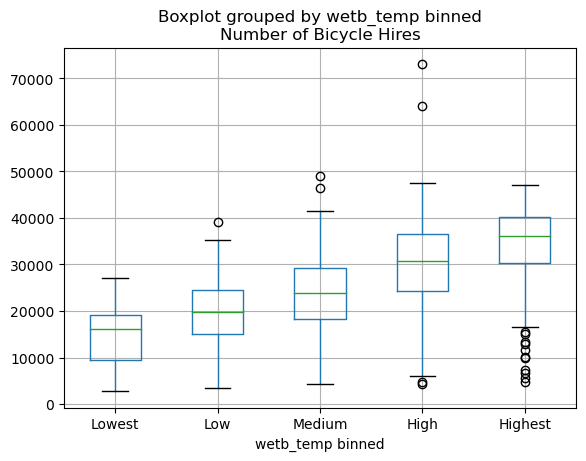

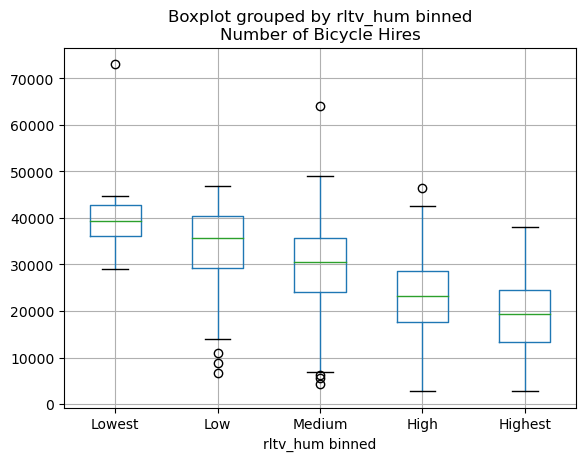

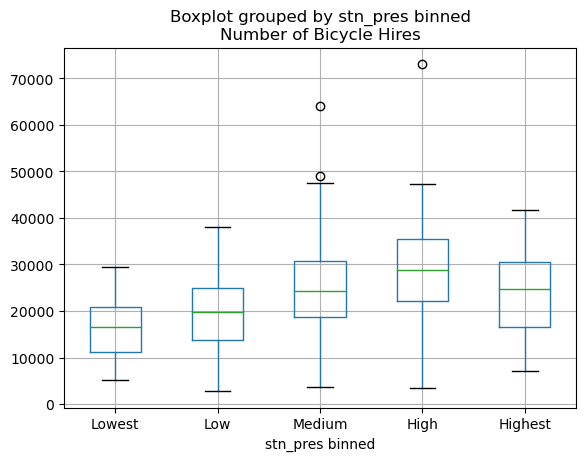

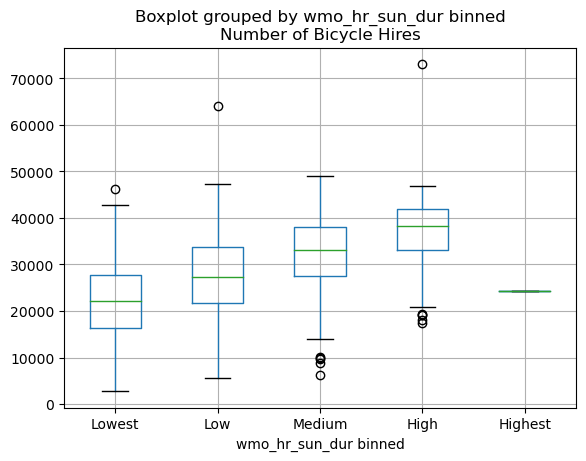

In [110]:
# generate boxplots

for col in weatherBinned.columns:
    if(col == 'Number of Bicycle Hires' or col == 'Day binned' or col == 'Number of Bicycle Hires binned'):
        continue
    weatherBinned.boxplot('Number of Bicycle Hires', col)


In [424]:
# make specific bokeh plots that are actually used in the website: hires per day.
from bokeh.models import HoverTool, Line
from bokeh.models.tools import CustomJSHover
from bokeh.plotting import figure, output_file, show
output_file('numberOfHiresPerDay.html')
fig = figure(title = 'Bicycle hires day by day', x_axis_label = 'Date', y_axis_label = 'Bicycle hires', x_axis_type='datetime', plot_width=475, plot_height=190)
fig.line(weatherJoined['Day'],weatherJoined['Number of Bicycle Hires'])

x_custom = CustomJSHover(code="""
    return '' + special_vars.data_x
""")

y_custom = CustomJSHover(code="""
    return '' + special_vars.data_y
""")

fig.add_tools(
    HoverTool(
        show_arrow=False, 
        line_policy='next',
        tooltips=[
            ('Number of Bicycle hires', '$data_y')
        ],
        formatters=dict(
            X_value=x_custom,
            Y_value=y_custom
        )
    )
)
show(fig)

In [426]:
# make specific bokeh plots that are actually used in the website: temperatures per day.
from bokeh.models import HoverTool, Line
from bokeh.models.tools import CustomJSHover
from bokeh.plotting import figure, output_file, show
output_file('temperaturePerDay.html')
fig = figure(title = 'Temperatures day by day', x_axis_label = 'Date', y_axis_label = 'Temperature', x_axis_type='datetime', plot_width=475, plot_height=190)
fig.line(weatherJoined['Day'],weatherJoined['air_temperature'])

x_custom = CustomJSHover(code="""
    return '' + special_vars.data_x
""")

y_custom = CustomJSHover(code="""
    return '' + special_vars.data_y
""")

fig.add_tools(
    HoverTool(
        show_arrow=False, 
        line_policy='next',
        tooltips=[
            ('temperature', '$data_y')
        ],
        formatters=dict(
            X_value=x_custom,
            Y_value=y_custom
        )
    )
)
show(fig)

# Machine Learning Model to predict Bike-Sharing Demand

In [ ]:
# inspiration:
# notebook: https://github.com/shayanalibhatti/Predicting_Bike_Share_Demand_with_LSTM/blob/master/Bike_Share_Prediction_Code.ipynb
# articel: https://medium.com/analytics-vidhya/capital-bike-share-demand-prediction-using-machine-learning-3c6c2c958e82

In [111]:
bike_rentals.head()

Day  Number of Bicycle Hires
0 2010-07-30                     6897
1 2010-07-31                     5564
2 2010-08-01                     4303
3 2010-08-02                     6642
4 2010-08-03                     7966

In [112]:
bike_rentals.describe()

Number of Bicycle Hires
count              4204.000000
mean              26320.135347
std                9693.146364
min                2764.000000
25%               19271.000000
50%               26145.500000
75%               33371.000000
max               73094.000000

<AxesSubplot:>

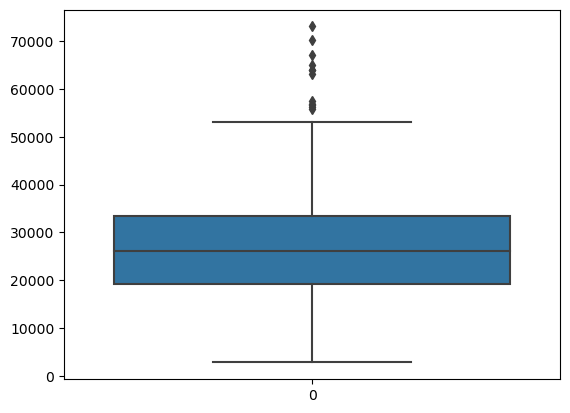

In [113]:
sns.boxplot(data = bike_rentals['Number of Bicycle Hires'])

In [114]:
pd.date_range(start = np.min(bike_rentals_weather.index), end = np.max(bike_rentals_weather.index) ).difference(bike_rentals_weather.index)
# missing a few dates -> 12


DatetimeIndex(['1970-01-01'], dtype='datetime64[ns]', freq='D')

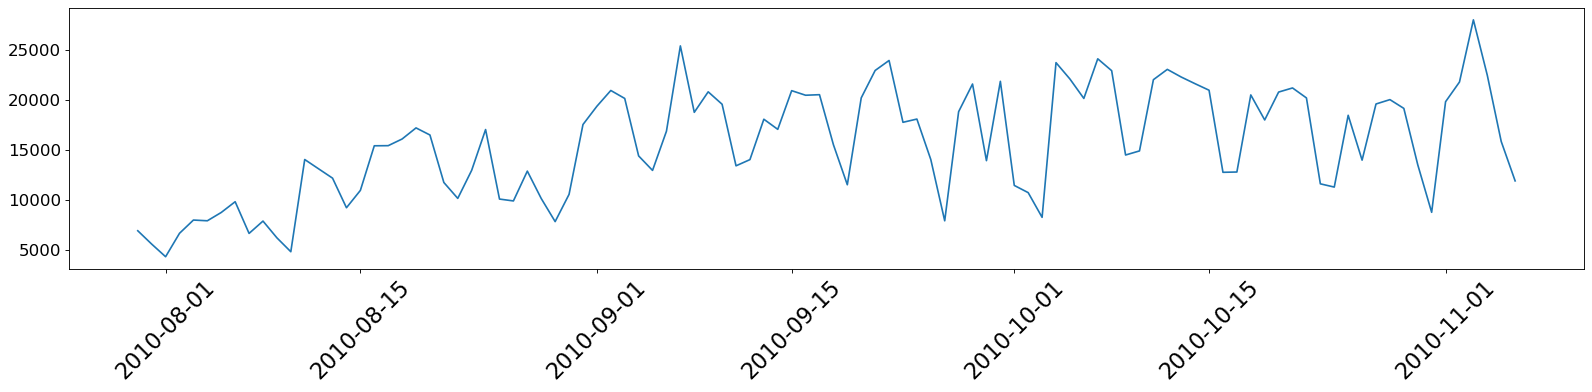

In [115]:
bike_rentals.head()

plt.figure(figsize=(20, 5), dpi=80)
plt.plot(bike_rentals['Day'][:100], bike_rentals['Number of Bicycle Hires'][:100])
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [116]:
bike_rentals_weather.head()

# drop ob_time, 

# correlation of features:
# cld_base_ht, cld_ttl_amt_id -> -0.84
# dewpoint, air_temperature -> 0.89
# wetb_temp, air_temperature -> 0.98
# wetb_temp, dewpoint -> 0.96

# correltaion of features with the target (Number of Bicycle Hires)
# air_temperature -> 0.64
# weth_temp -> 0.57
# rltv_hum -> -0.55
# wmo_hr_sun_dur -> 0.54


# pairwise correlation -> choose the one with higher correlation with the target

# analysing only correlation is fine as no categorical variables

###
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

# def correlation(dataset, threshold):
#     col_corr = set()  # Set of all the names of correlated columns
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
#                 colname = corr_matrix.columns[i]  # getting the name of column
#                 col_corr.add(colname)
#     return col_corr

# correlation(bike_rentals_weather, 0.5)

Day  Number of Bicycle Hires  wind_direction  wind_speed  cld_ttl_amt_id  cld_base_ht   visibility  msl_pressure  air_temperature   dewpoint  wetb_temp   rltv_hum     stn_pres  wmo_hr_sun_dur
0 2010-07-30                     6897      267.500000    6.791667        5.500000   123.750000  1883.333333   1014.687500        17.558333  10.479167  13.741667  64.450000  1011.712500        0.130435
1 2010-07-31                     5564      240.000000    9.333333        5.291667   102.083333  2919.583333   1011.554167        19.858333  13.708333  16.358333  69.808333  1008.612500        0.204348
2 2010-08-01                     4303      261.250000    5.916667        7.208333   156.666667  2879.166667   1013.225000        18.795833  11.125000  14.591667  62.675000  1010.266667        0.017391
3 2010-08-02                     6642      247.083333    4.708333        6.500000   173.333333  2470.833333   1016.791667        18.837500  10.483333  14.304167  59.066667  1013.833333        0.091304
4 2010-08-03                     7966      256.666667    6.750000        4.666667   177.083333  1908.333333   1015.687500        17.870833  11.225000  14.225000  66.145833  1012.729167        0.169565

In [117]:
# LSTM Model
# imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch.autograd import Variable
from torch import nn

# source
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

In [169]:
# # model is too complex -> less features
# bike_rentals.head()

Day  Number of Bicycle Hires
0 2010-07-30                     6897
1 2010-07-31                     5564
2 2010-08-01                     4303
3 2010-08-02                     6642
4 2010-08-03                     7966

In [242]:
# Preprocessing
bike_rentals_weather = bike_rentals_weather.set_index('Day')
bike_rentals_weather = bike_rentals_weather.dropna()
X, y = bike_rentals_weather, bike_rentals_weather['Number of Bicycle Hires'].values
X.shape, y.shape

((3376, 13), (3376,))

In [194]:
# # Preprocessing
# bike_rentals = bike_rentals.set_index('Day')
# bike_rentals = bike_rentals.dropna()
# X, y = bike_rentals, bike_rentals.values
# X.shape, y.shape

((4204, 1), (4204, 1))

In [244]:
# Feature Scaling
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [337]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 1500, 500) # based the last 1500 predict the next 500
print(X_ss.shape, y_mm.shape)

(1378, 1500, 13) (1378, 500)


In [338]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)
test_size = round((bike_rentals_weather.shape[0]*0.2))

X_train = X_ss[:-test_size]
X_test = X_ss[-test_size:]

y_train = y_mm[:-test_size]
y_test = y_mm[-test_size:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (703, 1500, 13) (703, 500)
Testing Shape: (675, 1500, 13) (675, 500)


In [339]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [340]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 1500, # n_steps_in
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 1500, # n_steps_in
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([703, 1500, 13]) torch.Size([703, 500])
Testing Shape: torch.Size([675, 1500, 13]) torch.Size([675, 500])


In [341]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [342]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [343]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 40 # 1000 epochs # 100 seems good
learning_rate = 0.001 # 0.001 lr

input_size = 13 # number of features
hidden_size = 8 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 500 # number of output classes # n_steps_out

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [344]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate) #changed optim from Adam to RMSprop # , weight_decay= 1e-4

# SDG optimizer?

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.15316, test loss: 0.15506
Epoch: 10, train loss: 0.08217, test loss: 0.08357
Epoch: 20, train loss: 0.03736, test loss: 0.03853
Epoch: 30, train loss: 0.02141, test loss: 0.02302


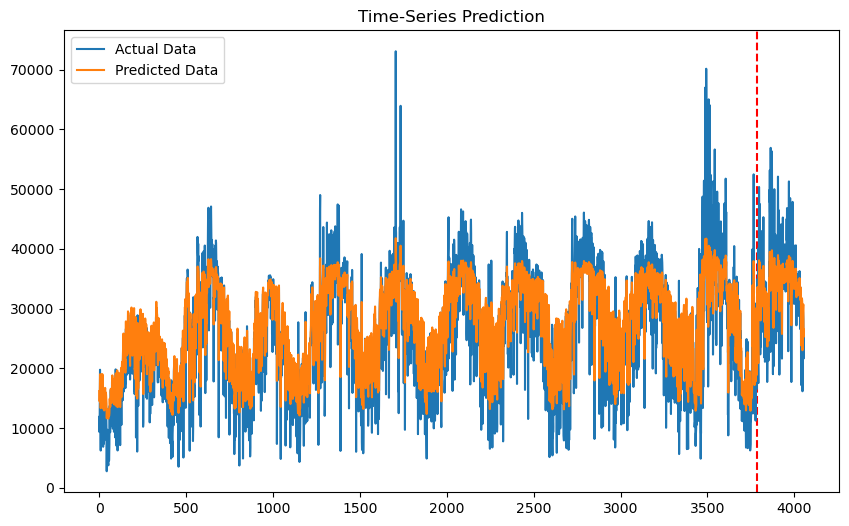

In [240]:
df_X_ss = ss.transform(bike_rentals) # old transformers
df_y_mm = mm.transform(bike_rentals.values) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show()

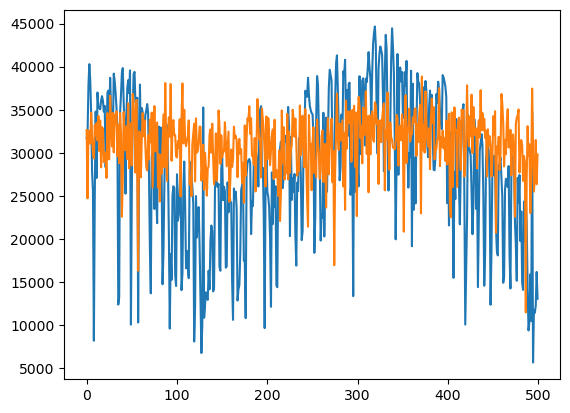

In [345]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

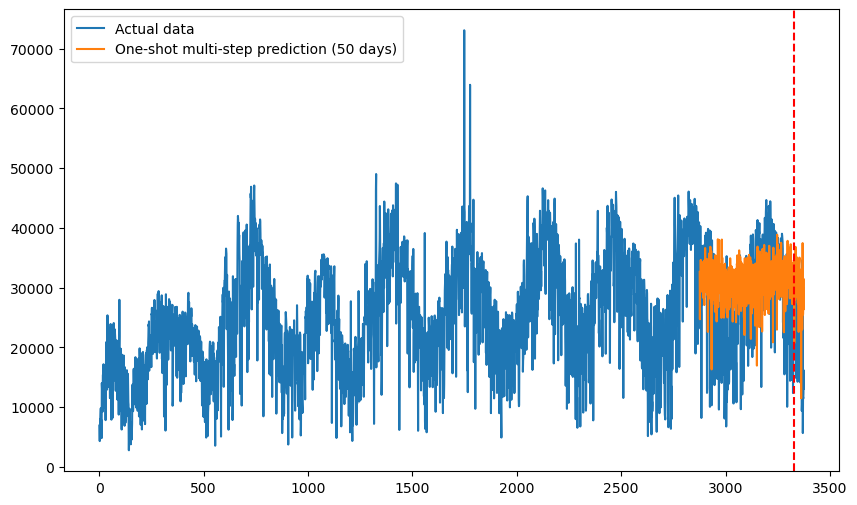

In [348]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2500, len(y))]
plt.plot(y, label='Actual data');
c = [x for x in range(len(y)-500, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()


In [ ]:
# Preprocessing
bike_rentals_weather = bike_rentals_weather.set_index('Day')
bike_rentals_weather = bike_rentals_weather.dropna()

In [475]:
bike_rentals_weather.columns

Index(['Number of Bicycle Hires', 'wind_direction', 'wind_speed', 'cld_ttl_amt_id', 'cld_base_ht', 'visibility', 'msl_pressure', 'air_temperature', 'dewpoint', 'wetb_temp', 'rltv_hum', 'stn_pres', 'wmo_hr_sun_dur'], dtype='object')

In [447]:
# source: https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0#scrollTo=0LdAvhCnCMDL
train_data, test_data = train_test_split(bike_rentals_weather, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler = scaler.fit(train_data)
scaler_y = scaler_y.fit(train_data['Number of Bicycle Hires'].values.reshape(-1, 1))

train_data = scaler.transform(train_data)

test_data = scaler.transform(test_data)


train_data.shape, test_data.shape

((2363, 13), (1013, 13))

In [448]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    datax = data[:]
    datay = data[:, 0]

    for i in range(len(data)-seq_length-1):
        x = datax[i:(i+seq_length)]
        y = datay[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [470]:
seq_length = 15
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).unsqueeze(-1).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).unsqueeze(-1).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([2347, 15, 13]),
 torch.Size([2347, 1]),
 torch.Size([997, 15, 13]),
 torch.Size([997, 1]))

In [486]:
class BikeSharingDemandPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(BikeSharingDemandPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [487]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4) #a dded , weight_decay= 1e-4
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [488]:
model = BikeSharingDemandPredictor(
  n_features=13, # neurons in input layer
  n_hidden=3, # neurons in hidden layer
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

RuntimeError: Expected hidden[0] size (2, 2347, 3), got [2, 15, 3]

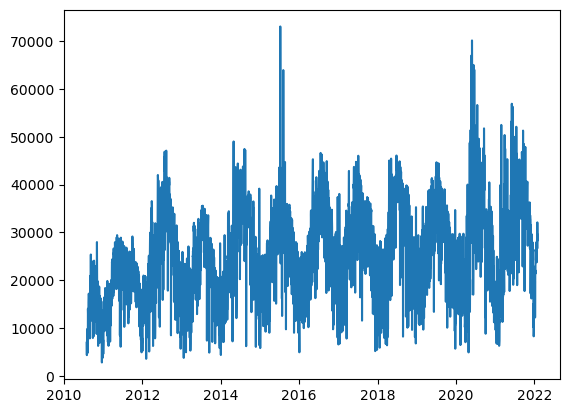

In [351]:
plt.plot(bike_rentals)

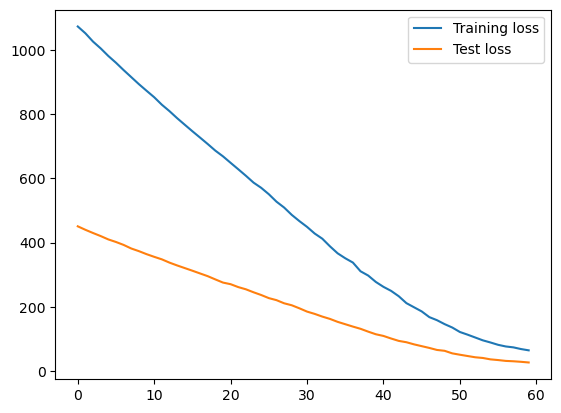

In [484]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")

plt.legend();

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 13).float() # last number in view = amount of features


In [ ]:
# rescaling
# true_cases = scaler_y.inverse_transform(.reshape(-1, 1))#.flatten()

true_rentals = bike_rentals_weather['Number of Bicycle Hires'].values

predicted_rentals = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1))#.flatten()

In [440]:
plt.plot(
  bike_rentals_weather.index[:len(train_data)], 
  true_rentals[:len(train_data)],
  label='Historical Bike Rentals'
)

plt.plot(
  bike_rentals_weather.index[len(train_data):], 
  true_rentals[len(train_data):],
  label='Real Bike Rentals'
)

# plt.plot(
#   bike_rentals_weather.index[len(train_data):], 
#   predicted_rentals, 
#   label='Predicted Predicted Bike Rentals'
# )

plt.legend();

NameError: name 'train_data' is not defined

In [ ]:
bike_rentals_weather.index[:len(train_data)]

DatetimeIndex(['2010-07-30', '2010-07-31', '2010-08-01', '2010-08-02', '2010-08-03', '2010-08-04', '2010-08-05', '2010-08-06', '2010-08-07', '2010-08-08',
               ...
               '2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09', '2017-03-10', '2017-03-11', '2017-03-12', '2017-03-13', '2017-03-14'], dtype='datetime64[ns]', name='Day', length=2363, freq=None)

In [ ]:
true_cases[:len(train_data)].shape

(997, 1)

In [ ]:
true_cases.shape

(997, 1)

In [215]:
y.values

array([[ 6897],
       [ 5564],
       [ 4303],
       ...,
       [32087],
       [27463],
       [26806]], dtype=int64)